# Evaluation script

## Load packages

In [3]:
Sys.setenv("PKG_CXXFLAGS"="-std=c++14")

# List of required packages
list_of_packages <- c("here", "dplyr", "ggplot2", "reshape2", "xtable", "writexl", "tidyr")

# Function to load packages and handle errors
load_if_installed <- function(p) {
  tryCatch({
    library(p, character.only = TRUE)
  }, error = function(e) {
    message(sprintf("Package '%s' is not installed.", p))
  })
}

# Load all required packages
lapply(list_of_packages, load_if_installed)

here() starts at /Users/emmafoessing/Documents/Master/MA/Code/Master-Thesis


Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union



Attache Paket: 'tidyr'


Das folgende Objekt ist maskiert 'package:reshape2':

    smiths




[[1]]
 [1] "here"      "reshape2"  "ggplot2"   "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "dplyr"     "here"      "reshape2"  "ggplot2"   "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "dplyr"     "here"      "reshape2"  "ggplot2"   "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "dplyr"     "here"      "reshape2"  "ggplot2"   "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "xtable"    "dplyr"     "here"      "reshape2"  "ggplot2"   "stats"    
 [7] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "writexl"   "xtable"    "dplyr"     "here"      "reshape2"  "ggplot2"  
 [7] "stats"     "graphics"  "grDevices" "utils"     "datasets"  "methods"  
[13] "base"     

[[7]]
 [1] "tidyr"     "writexl"   "xtable"    "dplyr"     "here"      "reshape2" 
 [7] "ggplot2"   "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[13] "methods"   "base"

## Load results

In [4]:
datanames <- c("cps", "adult")
modelnames <- c("orig", "orig_dis", "cart", "rf", "bn", "xgb", "svm")
seeds <- 1235:1244

loaded_data <- list()

# Loop through all combinations of dataname and modelname
for (dataname in datanames) {
  for (modelname in modelnames) {
    for (seed in seeds) {
      # Construct the file path
      file_path <- paste0(here(), "/results/", dataname, "_", modelname, "_res_", seed, ".RData")
      
      # Check if the file exists
      if (file.exists(file_path)) {
        # Create a new environment to load the RData
        env <- new.env()
        
        # Load the file into the environment
        load(file = file_path, envir = env)
        
        # Assume the result object inside the RData file is always named "cps_res" or "adult_res"
        # Check which object is in the environment and assign it to the list under a unique name
        result_name <- ls(env)[1]  # Get the name of the loaded object (either cps_res or adult_res)
        
        # Rename "orig" to "og" when saving
        save_modelname <- ifelse(modelname == "orig", "og", modelname)
        loaded_data[[paste0(dataname, "_", save_modelname, "_", seed)]] <- env[[result_name]]
        
        cat("Loaded data for:", dataname, save_modelname, seed, "\n")
      } else {
        # Print message if the file does not exist
        cat("Data does not exist for:", dataname, modelname, seed, "\n")
      }
    }
  }
}

# Print all loaded dataframes
cat("\n--- List of loaded dataframes ---\n")
for (name in names(loaded_data)) {
  cat("Data for:", name, "\n")
  print(loaded_data[[name]])
}


Loaded data for: cps og 1235 
Loaded data for: cps og 1236 
Loaded data for: cps og 1237 
Loaded data for: cps og 1238 
Loaded data for: cps og 1239 
Loaded data for: cps og 1240 
Loaded data for: cps og 1241 
Loaded data for: cps og 1242 
Loaded data for: cps og 1243 
Loaded data for: cps og 1244 
Loaded data for: cps orig_dis 1235 
Loaded data for: cps orig_dis 1236 
Loaded data for: cps orig_dis 1237 
Loaded data for: cps orig_dis 1238 
Loaded data for: cps orig_dis 1239 
Loaded data for: cps orig_dis 1240 
Loaded data for: cps orig_dis 1241 
Loaded data for: cps orig_dis 1242 
Loaded data for: cps orig_dis 1243 
Loaded data for: cps orig_dis 1244 
Loaded data for: cps cart 1235 
Loaded data for: cps cart 1236 
Loaded data for: cps cart 1237 
Loaded data for: cps cart 1238 
Loaded data for: cps cart 1239 
Loaded data for: cps cart 1240 
Loaded data for: cps cart 1241 
Loaded data for: cps cart 1242 
Loaded data for: cps cart 1243 
Loaded data for: cps cart 1244 
Loaded data for: cps

In [5]:
print(loaded_data[["cps_og_1235"]])

[[1]]
          MAE        MSE     RMSE R_squared     MAPE
CART 26383.18 1724445436 41521.48 0.2877267 4549.470
RF   25029.53 1596826192 39953.84 0.3403154 4335.911
XGB  24845.18 1585614630 39813.89 0.3450706 4314.250
SVM  24072.22 1689887339 41105.99 0.3020326 3666.865

[[2]]
   Accuracy        F1 Sensitivity Specificity
1 0.9603934 0.9797966        0.22         0.8



## Average results over seeds

In [6]:
modelnames <- c("og", "orig_dis", "cart", "rf", "bn", "xgb", "svm")

# Function to average a list of dataframes, ensuring they are of the same size
average_dataframes <- function(df_list) {
  # Check that all dataframes have the same dimensions
  first_df <- df_list[[1]]
  same_size <- sapply(df_list, function(x) all(dim(x) == dim(first_df)))
  
  if (all(same_size)) {
    df_avg <- Reduce("+", df_list) / length(df_list)
    return(df_avg)
  } else {
    cat("Dataframes do not have the same size. Printing the dataframes:\n")
    for (i in seq_along(df_list)) {
      cat("Dataframe", i, ":\n")
      print(df_list[[i]])
      cat("\n")
    }
    stop("Not all dataframes have the same size.")
  }
}

# Initialize list to store averaged results
averaged_data <- list()

# Loop through the datanames and modelnames to average dataframes
for (dataname in datanames) {
  for (modelname in modelnames) {
    # Filter the list of loaded data for the current dataname and modelname
    data_key <- paste0(dataname, "_", modelname, "_")
    model_data <- loaded_data[grep(data_key, names(loaded_data))]
    
    # If the model data for this combination is available, average the dataframes
    if (length(model_data) > 0) {
      if (dataname == "cps") {
        # For cps data, extract the nested lists
        first_df_list <- lapply(model_data, function(x) x[[1]])  # Extract first dataframe
        second_df_list <- lapply(model_data, function(x) x[[2]])  # Extract second dataframe
        
        # Average the first and second dataframes separately over the seeds
        cat("Averaging first dataframe for:", dataname, modelname, "\n")
        averaged_data[[paste0(dataname, "_", modelname)]] <- average_dataframes(first_df_list)
        
        cat("Averaging second dataframe for:", dataname, modelname, "\n")
        averaged_data[[paste0(dataname, "_", modelname, "_bn_pred")]] <- average_dataframes(second_df_list)
        
      } else if (dataname == "adult") {
        # For adult data, extract the single dataframe from the nested structure
        df_list <- lapply(model_data, function(x) x[[1]])
        
        # Average the dataframe over the seeds
        cat("Averaging dataframe for:", dataname, modelname, "\n")
        averaged_data[[paste0(dataname, "_", modelname)]] <- average_dataframes(df_list)
      }
      
      cat("Averaged data for:", dataname, modelname, "\n")
    } else {
      cat("No data to average for:", dataname, modelname, "\n")
    }
  }
}

# Print the averaged dataframes
for (name in names(averaged_data)) {
  cat("Averaged data for:", name, "\n")
  print(averaged_data[[name]])
}

Averaging first dataframe for: cps og 
Averaging second dataframe for: cps og 
Averaged data for: cps og 
Averaging first dataframe for: cps orig_dis 
Averaging second dataframe for: cps orig_dis 
Averaged data for: cps orig_dis 
Averaging first dataframe for: cps cart 
Averaging second dataframe for: cps cart 
Averaged data for: cps cart 
Averaging first dataframe for: cps rf 
Averaging second dataframe for: cps rf 
Averaged data for: cps rf 
Averaging first dataframe for: cps bn 
Averaging second dataframe for: cps bn 
Averaged data for: cps bn 
Averaging first dataframe for: cps xgb 
Averaging second dataframe for: cps xgb 
Averaged data for: cps xgb 
Averaging first dataframe for: cps svm 
Averaging second dataframe for: cps svm 
Averaged data for: cps svm 
Averaging dataframe for: adult og 
Averaged data for: adult og 
Averaging dataframe for: adult orig_dis 
Averaged data for: adult orig_dis 
Averaging dataframe for: adult cart 
Averaged data for: adult cart 
Averaging dataframe 

## Metric Tables

In [7]:
# Define the datasets and models
datanames <- c("cps", "adult")
modelnames <- c("og", "cart", "rf", "xgb", "svm")  # Excluding "orig_dis"
metrics_regression <- c("MAE", "MSE", "RMSE", "R_squared", "MAPE") # For cps
metrics_classification <- c("Accuracy", "F1", "Sensitivity", "Specificity") # For adult

# Initialize empty data frames for cps and adult datasets
cps_table <- data.frame(matrix(ncol = length(modelnames) + 2, nrow = 0))  # +2 for model and metric columns
colnames(cps_table) <- c("Prediction Model", "Metric", "Original Data", "CART-syn. Data", "RF-syn. Data", "XGB-syn. Data", "SVM-syn. Data")

adult_table <- data.frame(matrix(ncol = length(modelnames) + 2, nrow = 0))  # +2 for model and metric columns
colnames(adult_table) <- c("Prediction Model", "Metric", "Original Data", "CART-syn. Data", "RF-syn. Data", "XGB-syn. Data", "SVM-syn. Data")

# Fill in the cps table with regression metrics
for (model in c("CART", "RF", "XGB", "SVM")) {
  for (metric in metrics_regression) {
    row <- c(model, metric)
    for (modelname in modelnames) {
      df_name <- paste0("cps_", modelname)
      if (!is.null(averaged_data[[df_name]])) {
        regression_metrics <- averaged_data[[df_name]]
        if (!is.null(regression_metrics) && !is.null(regression_metrics[model, metric])) {
          row <- c(row, regression_metrics[model, metric])
        } else {
          row <- c(row, NA)
        }
      } else {
        row <- c(row, NA)
      }
    }
    cps_table <- rbind(cps_table, row)
  }
}

# Fill in the adult table with classification metrics
for (model in c("CART", "RF", "XGB", "SVM", "BN")) {
  for (metric in metrics_classification) {
    row <- c(model, metric)
    for (modelname in modelnames) {
      df_name <- paste0("adult_", modelname)
      if (!is.null(averaged_data[[df_name]])) {
        classification_metrics <- averaged_data[[df_name]]
        if (!is.null(classification_metrics) && !is.null(classification_metrics[model, metric])) {
          row <- c(row, classification_metrics[model, metric])
        } else {
          row <- c(row, NA)
        }
      } else {
        row <- c(row, NA)
      }
    }
    adult_table <- rbind(adult_table, row)
  }
}

# Print the tables with correct column names
cat("\n--- CPS Dataset Table (Regression) ---\n")
colnames(cps_table) <- c("Prediction Model", "Metric", "Original data", "CART-syn. data", "RF-syn. data", "XGB-syn. data", "SVM/R-syn. data")
print(cps_table)

cat("\n--- Adult Dataset Table (Classification) ---\n")
colnames(adult_table) <- c("Prediction Model", "Metric", "Original data", "CART-syn. data", "RF-syn. data", "XGB-syn. data", "SVM/R-syn. data")
print(adult_table)



--- CPS Dataset Table (Regression) ---
   Prediction Model    Metric     Original data    CART-syn. data
1              CART       MAE  26343.3260164423  26178.4902694942
2              CART       MSE  1714859596.86429  1705863260.39886
3              CART      RMSE  41407.1577894658  41289.5052688397
4              CART R_squared  0.29163923072279 0.295275745991159
5              CART      MAPE  4530.66826991606  4747.17078716042
6                RF       MAE  25034.9584160487  24540.4966459923
7                RF       MSE  1595924953.69996  1549769835.40984
8                RF      RMSE   39942.327242501  39356.3951168788
9                RF R_squared 0.340880001796521 0.359754486972922
10               RF      MAPE  4340.00487060294  4407.40395529833
11              XGB       MAE  24831.1398064914  24510.8488643531
12              XGB       MSE  1583878594.25728  1549601719.90557
13              XGB      RMSE   39790.273069657  39355.7747158373
14              XGB R_squared  0.345

In [8]:
cps_table

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,MAE,26343.3260164423,26178.4902694942,29679.6329494522,33607.1805763609,1348450909741667
CART,MSE,1714859596.86429,1705863260.39886,2049007653.38704,2404325889.0473,2.5787733877618e+31
CART,RMSE,41407.1577894658,41289.5052688397,45256.9219813804,49024.0530333112,4971040554279611
CART,R_squared,0.29163923072279,0.295275745991159,0.136492535572256,0.00787676321385017,-0.00253246606206582
CART,MAPE,4530.66826991606,4747.17078716042,3835.94918173852,NaN,NaN
RF,MAE,25034.9584160487,24540.4966459923,29138.6183892165,33686.0111884192,1347339093216366
RF,MSE,1595924953.69996,1549769835.40984,1996587550.41812,2410918011.79466,2.56716093426476e+31
RF,RMSE,39942.327242501,39356.3951168788,44670.6986245275,49093.2028765215,4960469480837069
RF,R_squared,0.340880001796521,0.359754486972922,0.158654974419597,0.00515816463493392,0.00194359231470616


In [9]:
# Reorder cps_table by metric
cps_table_metric_ordered <- cps_table %>%
  arrange(Metric) %>%
  filter(Metric != "MAPE")

cps_table_metric_ordered

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,MAE,26343.3260164423,26178.4902694942,29679.6329494522,33607.1805763609,1348450909741667
RF,MAE,25034.9584160487,24540.4966459923,29138.6183892165,33686.0111884192,1347339093216366
XGB,MAE,24831.1398064914,24510.8488643531,28986.3671764169,33615.5693366872,1348951287810318
SVM,MAE,24080.6320531298,23928.5528632922,27906.2933645,31962.0718938016,1060587718397631
CART,MSE,1714859596.86429,1705863260.39886,2049007653.38704,2404325889.0473,2.5787733877618e+31
RF,MSE,1595924953.69996,1549769835.40984,1996587550.41812,2410918011.79466,2.56716093426476e+31
XGB,MSE,1583878594.25728,1549601719.90557,1988414595.86452,2400645691.99728,2.57012706218874e+31
SVM,MSE,1689493173.73163,1676849659.69535,2106843603.43927,2586428611.78139,2.59709000545821e+31
CART,RMSE,41407.1577894658,41289.5052688397,45256.9219813804,49024.0530333112,4971040554279611


In [10]:
write_xlsx(cps_table_metric_ordered, "results/cps_res_presentation.xlsx")

In [11]:
adult_table

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,Accuracy,0.853441417648823,0.854671443133496,0.85073199121601,0.750251973462735,0.52349902620941
CART,F1,0.906217222833311,0.906552193413809,0.903469855874936,0.85729893009612,0.686709586651726
CART,Sensitivity,0.942751830290523,0.939825628333379,0.935781716575136,0.999951234824903,0.997602798955674
CART,Specificity,0.583964387700698,0.598996801105329,0.600075574171273,0.000119052368837452,0.00244539083502834
RF,Accuracy,0.860848156137676,0.868506797105652,0.860070494276981,0.750281812381658,0.523097509358673
RF,F1,0.910147822028902,0.914887020060937,0.909023720380285,0.857302218550889,0.685430895785219
RF,Sensitivity,0.938337581234595,0.942188104679518,0.936527121949292,0.999858485572361,0.992780558018062
RF,Specificity,0.627038166300141,0.647319062933176,0.634833045600497,0.000517637879966009,0.00686610421045814
XGB,Accuracy,0.868970829250288,0.870612106703776,0.854997748414834,0.724404861101322,0.503617618462432


In [12]:
# Reorder adult_table by metric
adult_table_metric_ordered <- adult_table %>%
  arrange(Metric) %>%
  filter(`Prediction Model` != "BN") # Filter out BN

adult_table_metric_ordered

Prediction Model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CART,Accuracy,0.853441417648823,0.854671443133496,0.85073199121601,0.750251973462735,0.52349902620941
RF,Accuracy,0.860848156137676,0.868506797105652,0.860070494276981,0.750281812381658,0.523097509358673
XGB,Accuracy,0.868970829250288,0.870612106703776,0.854997748414834,0.724404861101322,0.503617618462432
SVM,Accuracy,0.810718709427368,0.808034261305554,0.775162428189315,0.750218815038825,NA
CART,F1,0.906217222833311,0.906552193413809,0.903469855874936,0.85729893009612,0.686709586651726
RF,F1,0.910147822028902,0.914887020060937,0.909023720380285,0.857302218550889,0.685430895785219
XGB,F1,0.915057167781471,0.915838520393458,0.905451398998628,0.837606397354582,0.543793091062038
SVM,F1,0.882538741950765,0.882310465616764,0.867117596347998,0.857277249929833,NA
CART,Sensitivity,0.942751830290523,0.939825628333379,0.935781716575136,0.999951234824903,0.997602798955674


In [13]:
write_xlsx(adult_table_metric_ordered, "results/adult_res_presentation.xlsx")

### Extra BN Tables

#### BN Prediction Model Metrics on Different Synthetic Models' Data

In [14]:
# Create a function to extract the relevant columns from the averaged dataframes
generate_table <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "Original data" = numeric(),
    "CART-syn. data" = numeric(),
    "RF-syn. data" = numeric(),
    "XGB-syn. data" = numeric(),
    "SVM-syn. data" = numeric(),
    "BN-syn. data" = numeric(),  # New column for BN-syn. data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")
  
  # Extract data for each metric
  for (metric in metrics) {
    # Check if the metric exists in each dataframe
    og_values <- if (metric %in% colnames(averaged_data[["cps_og_bn_pred"]])) averaged_data[["cps_og_bn_pred"]][, metric] else NA
    cart_values <- if (metric %in% colnames(averaged_data[["cps_cart_bn_pred"]])) averaged_data[["cps_cart_bn_pred"]][, metric] else NA
    rf_values <- if (metric %in% colnames(averaged_data[["cps_rf_bn_pred"]])) averaged_data[["cps_rf_bn_pred"]][, metric] else NA
    xgb_values <- if (metric %in% colnames(averaged_data[["cps_xgb_bn_pred"]])) averaged_data[["cps_xgb_bn_pred"]][, metric] else NA
    svm_values <- if (metric %in% colnames(averaged_data[["cps_svm_bn_pred"]])) averaged_data[["cps_svm_bn_pred"]][, metric] else NA
    bn_syn_values <- if (metric %in% colnames(averaged_data[["cps_bn_bn_pred"]])) averaged_data[["cps_bn_bn_pred"]][, metric] else NA
    
    # Ensure all values have the same length (they should all be length 1 in this case)
    if (length(og_values) == 1 && length(cart_values) == 1 && length(rf_values) == 1 && 
        length(xgb_values) == 1 && length(svm_values) == 1 && length(bn_syn_values) == 1) {
      # Create a new row for the result table
      new_row <- data.frame(
        "prediction model" = "BN",
        "metric" = metric,
        "Original data" = og_values,
        "CART-syn. data" = cart_values,
        "RF-syn. data" = rf_values,
        "XGB-syn. data" = xgb_values,
        "SVM-syn. data" = svm_values,
        "BN-syn. data" = bn_syn_values,  # Include BN-syn. data
        stringsAsFactors = FALSE
      )
      
      # Append the new row to the result dataframe
      result_df <- rbind(result_df, new_row)
    } else {
      cat("Metric", metric, "is not available for all models\n")
    }
  }
  
  return(result_df)
}

# Generate the table using the function
result_table <- generate_table(averaged_data)

# Print the result table
result_table


prediction.model,metric,Original.data,CART.syn..data,RF.syn..data,XGB.syn..data,SVM.syn..data,BN.syn..data
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BN,Accuracy,0.9603890,0.9454136,0.9518807,0.9476514,0.9903850,0.9600016
BN,F1,0.9797943,0.9718764,0.9752820,0.9730208,0.9203179,0.9795925
BN,Sensitivity,0.2200000,0.2080000,0.2070000,0.1806667,0.4443436,0.2190000
BN,Specificity,0.8000000,0.8000000,0.8000000,0.8333333,0.9436102,0.8000000


In [15]:
write_xlsx(result_table, "results/cps_bn_res_presentation.xlsx")

In [16]:
# Create a function to generate a table for the adult data, including the BN prediction model
generate_adult_table <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "Original data" = numeric(),
    "CART-syn. data" = numeric(),
    "RF-syn. data" = numeric(),
    "XGB-syn. data" = numeric(),
    "SVM-syn. data" = numeric(),
    "BN-syn. data" = numeric(),  # New column for BN-syn. data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")
  
  # Loop through each metric
  for (metric in metrics) {
    # Extract values from each model's dataframe, using NA if data is missing
    og_values <- if (metric %in% colnames(averaged_data[["adult_og"]])) averaged_data[["adult_og"]]["BN", metric] else NA
    cart_values <- if (metric %in% colnames(averaged_data[["adult_cart"]])) averaged_data[["adult_cart"]]["BN", metric] else NA
    rf_values <- if (metric %in% colnames(averaged_data[["adult_rf"]])) averaged_data[["adult_rf"]]["BN", metric] else NA
    xgb_values <- if (metric %in% colnames(averaged_data[["adult_xgb"]])) averaged_data[["adult_xgb"]]["BN", metric] else NA
    svm_values <- if (metric %in% colnames(averaged_data[["adult_svm"]])) averaged_data[["adult_svm"]]["BN", metric] else NA
    bn_syn_values <- if (metric %in% colnames(averaged_data[["adult_bn"]])) averaged_data[["adult_bn"]]["BN", metric] else NA
    
    # Create a new row for the result table
    new_row <- data.frame(
      "prediction model" = "BN",  # BN for synthesized data
      "metric" = metric,
      "Original data" = og_values,
      "CART-syn. data" = cart_values,
      "RF-syn. data" = rf_values,
      "XGB-syn. data" = xgb_values,
      "SVM-syn. data" = svm_values,
      "BN-syn. data" = bn_syn_values,
      stringsAsFactors = FALSE
    )
    
    # Append the new row to the result dataframe
    result_df <- rbind(result_df, new_row)
  }
  
  return(result_df)
}

# Generate the table using the function for adult data
adult_result_table <- generate_adult_table(averaged_data)

# Print the result table
print(adult_result_table)


  prediction.model      metric Original.data CART.syn..data RF.syn..data
1               BN    Accuracy     0.8264646      0.8270822    0.8301440
2               BN          F1     0.8868903      0.8358287    0.8307471
3               BN Sensitivity     0.9060926      0.8444277    0.8369992
4               BN Specificity     0.5864668      0.6474837    0.6600012
  XGB.syn..data SVM.syn..data BN.syn..data
1     0.7502537     0.5158381    0.8429782
2     0.8573050     0.4728444    0.8477829
3     1.0000000     0.5579275    0.8561314
4     0.0000000     0.4401174    0.6564429


In [17]:
write_xlsx(result_table, "results/adult_bn_res_presentation.xlsx")

In [18]:
result_table

prediction.model,metric,Original.data,CART.syn..data,RF.syn..data,XGB.syn..data,SVM.syn..data,BN.syn..data
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BN,Accuracy,0.9603890,0.9454136,0.9518807,0.9476514,0.9903850,0.9600016
BN,F1,0.9797943,0.9718764,0.9752820,0.9730208,0.9203179,0.9795925
BN,Sensitivity,0.2200000,0.2080000,0.2070000,0.1806667,0.4443436,0.2190000
BN,Specificity,0.8000000,0.8000000,0.8000000,0.8333333,0.9436102,0.8000000


In [19]:
# Create a function to generate a table for the discretized data, including the BN prediction model
generate_discretized_table <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "disc. CPS" = numeric(),   # Renamed column for CPS data
    "disc. adult" = numeric(), # New column for adult data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")
  
  # Define the prediction models in cps_orig_dis and adult_orig_dis
  prediction_models <- rownames(averaged_data[["cps_orig_dis"]])
  
  # Loop through each metric
  for (metric in metrics) {
    for (model in prediction_models) {
      # Extract the values for CPS discretized data
      cps_values <- if (metric %in% colnames(averaged_data[["cps_orig_dis"]])) averaged_data[["cps_orig_dis"]][model, metric] else NA
      
      # Extract the values for adult discretized data, including BN as a row in adult_orig_dis
      adult_values <- if (model %in% rownames(averaged_data[["adult_orig_dis"]]) && metric %in% colnames(averaged_data[["adult_orig_dis"]])) 
                      averaged_data[["adult_orig_dis"]][model, metric] else NA
      
      # Create a new row for the result table
      new_row <- data.frame(
        "prediction model" = model,
        "metric" = metric,
        "disc. CPS" = cps_values,   # Values for CPS data
        "disc. adult" = adult_values,  # Values for adult data
        stringsAsFactors = FALSE
      )
      
      # Append the new row to the result dataframe
      result_df <- rbind(result_df, new_row)
    }
    
    # Add the BN prediction model from cps_orig_dis_bn_pred for CPS data
    bn_cps_values <- if (metric %in% colnames(averaged_data[["cps_orig_dis_bn_pred"]])) averaged_data[["cps_orig_dis_bn_pred"]][, metric] else NA
    
    # BN for adult data is included in adult_orig_dis as a row
    bn_adult_values <- if ("BN" %in% rownames(averaged_data[["adult_orig_dis"]]) && metric %in% colnames(averaged_data[["adult_orig_dis"]])) 
                        averaged_data[["adult_orig_dis"]]["BN", metric] else NA
    
    # Create a new row for BN and add it to the result dataframe
    bn_row <- data.frame(
      "prediction model" = "BN",
      "metric" = metric,
      "disc. CPS" = bn_cps_values,   # BN for CPS data
      "disc. adult" = bn_adult_values,  # BN for adult data
      stringsAsFactors = FALSE
    )
    
    result_df <- rbind(result_df, bn_row)
  }
  
  return(result_df)
}

# Generate the table for discretized data including BN and disc. adult data
discretized_result_table <- generate_discretized_table(averaged_data)

# Print the result table
print(discretized_result_table)


   prediction.model      metric disc..CPS disc..adult
1              CART    Accuracy 0.9603791   0.8316757
2                RF    Accuracy 0.9603932   0.8371926
3               XGB    Accuracy 0.9604114   0.8431968
4               SVM    Accuracy 0.9603932   0.8152872
5                BN    Accuracy 0.9603940   0.8262161
6              CART          F1 0.9797912   0.8916508
7                RF          F1 0.9797965   0.8951397
8               XGB          F1 0.9019285   0.8981551
9               SVM          F1 0.9797965   0.8833293
10               BN          F1 0.9797969   0.8866629
11             CART Sensitivity 0.2199971   0.9221991
12               RF Sensitivity 0.2200000   0.9252052
13              XGB Sensitivity 0.2201137   0.9205837
14              SVM Sensitivity 0.2200000   0.9305817
15               BN Sensitivity 0.2200000   0.9053639
16             CART Specificity 0.8000166   0.5585375
17               RF Specificity 0.8000000   0.5716326
18              XGB Specific

#### CPS

In [20]:
generate_discretized_table <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "disc. CPS" = numeric(),   # Renamed column for CPS data
    "BN-Synthesized Data" = numeric(), # New column for BN-synthesized data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")

  rownames(averaged_data[["cps_orig_dis_bn_pred"]]) <- "BN"
  rownames(averaged_data[["cps_bn_bn_pred"]]) <- "BN"
  
  # Define the prediction models in cps_orig_dis and cps_bn
  prediction_models <- rownames(averaged_data[["cps_orig_dis"]])
  
  # Loop through each metric
  for (metric in metrics) {
    for (model in prediction_models) {
      # Extract the values for CPS discretized data
      cps_values <- if (metric %in% colnames(averaged_data[["cps_orig_dis"]])) averaged_data[["cps_orig_dis"]][model, metric] else NA
      
      # Extract the values for BN-synthesized data
      bn_values <- if (model %in% rownames(averaged_data[["cps_bn"]]) && metric %in% colnames(averaged_data[["cps_bn"]])) 
                      averaged_data[["cps_bn"]][model, metric] else NA
      
      # Create a new row for the result table
      new_row <- data.frame(
        "prediction model" = model,
        "metric" = metric,
        "disc. CPS" = cps_values,   # Values for CPS data
        "BN-Synthesized Data" = bn_values,  # Values for BN-synthesized data
        stringsAsFactors = FALSE
      )
      
      # Append the new row to the result dataframe
      result_df <- rbind(result_df, new_row)
    }
    
    # Add the BN prediction model from cps_orig_dis_bn_pred for CPS data
    bn_cps_values <- if (metric %in% colnames(averaged_data[["cps_orig_dis_bn_pred"]])) averaged_data[["cps_orig_dis_bn_pred"]][, metric] else NA
    
    # Add BN-synthesized data from cps_bn_bn_pred for BN model
    bn_bn_values <- if ("BN" %in% rownames(averaged_data[["cps_bn_bn_pred"]]) && metric %in% colnames(averaged_data[["cps_bn_bn_pred"]])) 
                        averaged_data[["cps_bn_bn_pred"]]["BN", metric] else NA
    
    # Create a new row for BN and add it to the result dataframe
    bn_row <- data.frame(
      "prediction model" = "BN",
      "metric" = metric,
      "disc. CPS" = bn_cps_values,   # BN for CPS data
      "BN-Synthesized Data" = bn_bn_values,  # BN for BN-synthesized data
      stringsAsFactors = FALSE
    )
    
    result_df <- rbind(result_df, bn_row)
  }
  
  return(result_df)
}

# Generate the table for discretized data including BN and CPS data
discretized_result_table <- generate_discretized_table(averaged_data)

# Print the result table
print(discretized_result_table)


   prediction.model      metric disc..CPS BN.Synthesized.Data
1              CART    Accuracy 0.9603791           0.9600028
2                RF    Accuracy 0.9603932           0.9599867
3               XGB    Accuracy 0.9604114           0.9600028
4               SVM    Accuracy 0.9603932           0.9600069
5                BN    Accuracy 0.9603940           0.9600016
6              CART          F1 0.9797912           0.9795932
7                RF          F1 0.9797965           0.9698506
8               XGB          F1 0.9019285           0.9698552
9               SVM          F1 0.9797965           0.9795953
10               BN          F1 0.9797969           0.9795925
11             CART Sensitivity 0.2199971           0.2189992
12               RF Sensitivity 0.2200000           0.2190066
13              XGB Sensitivity 0.2201137           0.2190125
14              SVM Sensitivity 0.2200000           0.2190000
15               BN Sensitivity 0.2200000           0.2190000
16      

In [21]:
write_xlsx(discretized_result_table, "results/cps_bn_res_presentation.xlsx")

#### Adult

In [22]:
generate_discretized_table_v2 <- function(averaged_data) {
  # Initialize an empty data frame to store results
  result_df_v2 <- data.frame(
    "prediction model" = character(),
    "metric" = character(),
    "disc. adult" = numeric(), # Discretized adult data
    "BN-Synthesized adult" = numeric(), # BN-synthesized adult data
    stringsAsFactors = FALSE
  )
  
  # Define the metrics to be extracted
  metrics <- c("Accuracy", "F1", "Sensitivity", "Specificity")
  
  # Define the prediction models in adult_orig_dis
  prediction_models <- rownames(averaged_data[["adult_orig_dis"]])
  
  # Loop through each metric
  for (metric in metrics) {
    for (model in prediction_models) {
      # Extract the values for adult discretized data
      adult_values <- if (model %in% rownames(averaged_data[["adult_orig_dis"]]) && metric %in% colnames(averaged_data[["adult_orig_dis"]])) 
                         averaged_data[["adult_orig_dis"]][model, metric] else NA
      
      # Extract the values for BN-synthesized adult data
      bn_adult_values <- if (model %in% rownames(averaged_data[["adult_bn"]]) && metric %in% colnames(averaged_data[["adult_bn"]])) 
                           averaged_data[["adult_bn"]][model, metric] else NA
      
      # Create a new row for the result table
      new_row <- data.frame(
        "prediction model" = model,
        "metric" = metric,
        "disc. adult" = adult_values,   # Values for discretized adult data
        "BN-Synthesized adult" = bn_adult_values,  # Values for BN-synthesized adult data
        stringsAsFactors = FALSE
      )
      
      # Append the new row to the result dataframe
      result_df_v2 <- rbind(result_df_v2, new_row)
    }
    
    # Handle BN prediction model for adult data directly from adult_bn
    bn_adult_values <- if ("BN" %in% rownames(averaged_data[["adult_bn"]]) && metric %in% colnames(averaged_data[["adult_bn"]])) 
                         averaged_data[["adult_bn"]]["BN", metric] else NA
    
    # Create a new row for BN and add it to the result dataframe
    bn_row <- data.frame(
      "prediction model" = "BN",
      "metric" = metric,
      "disc. adult" = bn_adult_values,  # BN for discretized adult data
      "BN-Synthesized adult" = bn_adult_values,  # BN for BN-synthesized adult data
      stringsAsFactors = FALSE
    )
    
    result_df_v2 <- rbind(result_df_v2, bn_row)
  }
  
  return(result_df_v2)
}

# Generate the table for discretized and BN-synthesized adult data
discretized_result_table_v2 <- generate_discretized_table_v2(averaged_data)

# Print the result table
print(discretized_result_table_v2)


   prediction.model      metric disc..adult BN.Synthesized.adult
1              CART    Accuracy   0.8316757            0.8344010
2                RF    Accuracy   0.8371926            0.8365427
3               XGB    Accuracy   0.8431968            0.8420561
4               SVM    Accuracy   0.8152872            0.8185101
5                BN    Accuracy   0.8262161            0.8429782
6                BN    Accuracy   0.8429782            0.8429782
7              CART          F1   0.8916508            0.8945574
8                RF          F1   0.8951397            0.8959183
9               XGB          F1   0.8981551            0.8988359
10              SVM          F1   0.8833293            0.8868692
11               BN          F1   0.8866629            0.8477829
12               BN          F1   0.8477829            0.8477829
13             CART Sensitivity   0.9221991            0.9299519
14               RF Sensitivity   0.9252052            0.9313385
15              XGB Sensi

In [23]:
write_xlsx(discretized_result_table_v2, "results/adult_bn_res_presentation.xlsx")

In [24]:
averaged_data[["adult_orig_dis"]]

,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.8316757,0.8916508,0.9221991,0.5585375
RF,0.8371926,0.8951397,0.9252052,0.5716326
XGB,0.8431968,0.8981551,0.9205837,0.6096967
SVM,0.8152872,0.8833293,0.9305817,0.4674074
BN,0.8262161,0.8866629,0.9053639,0.5876945


## Heatmaps for metrics

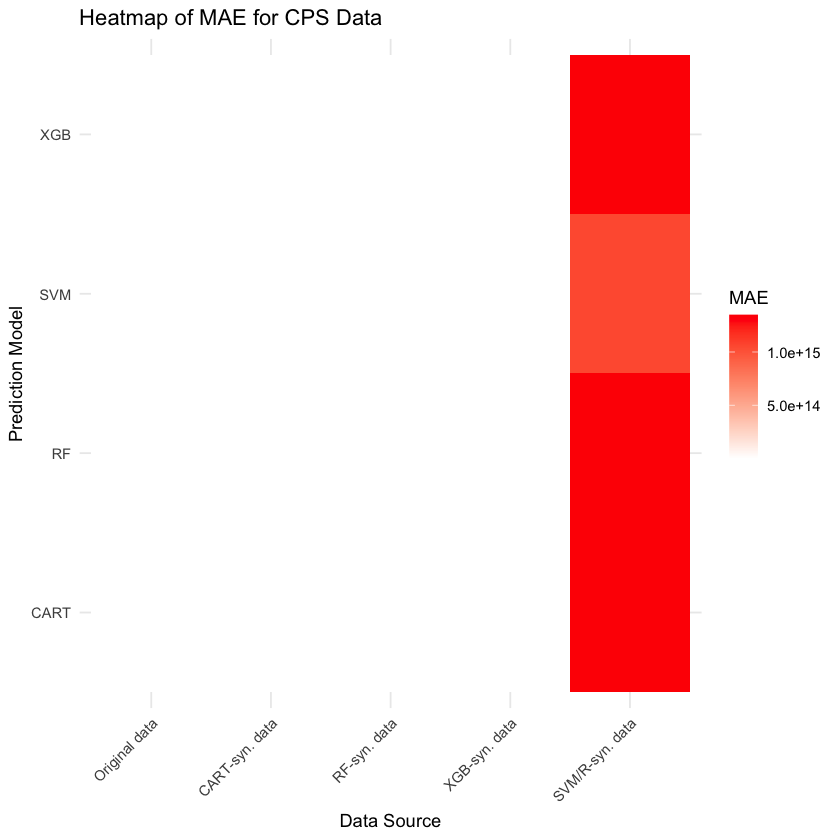

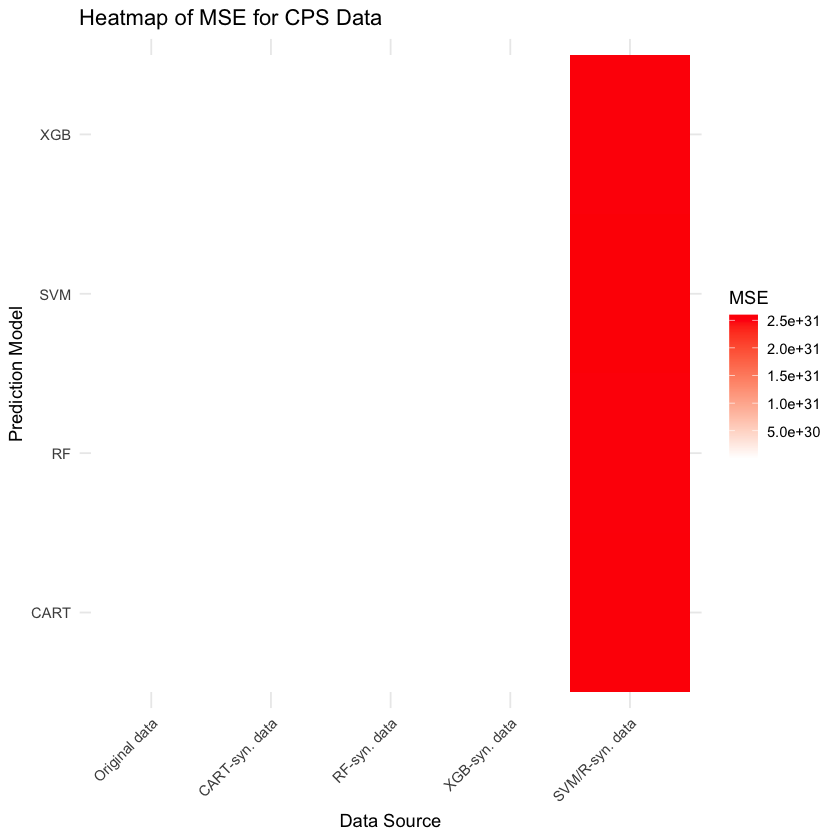

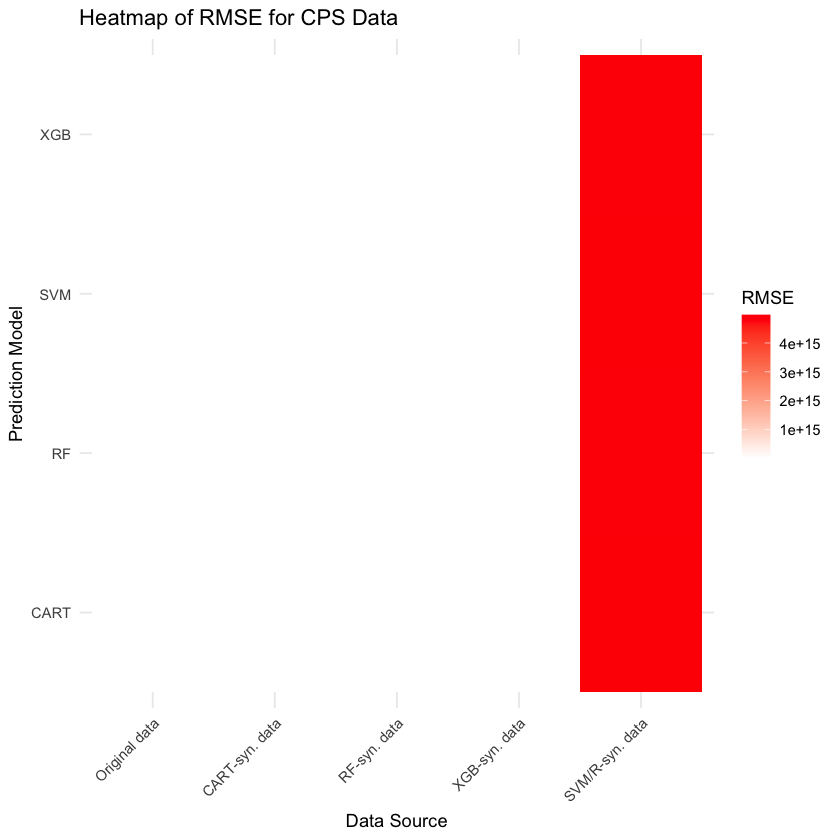

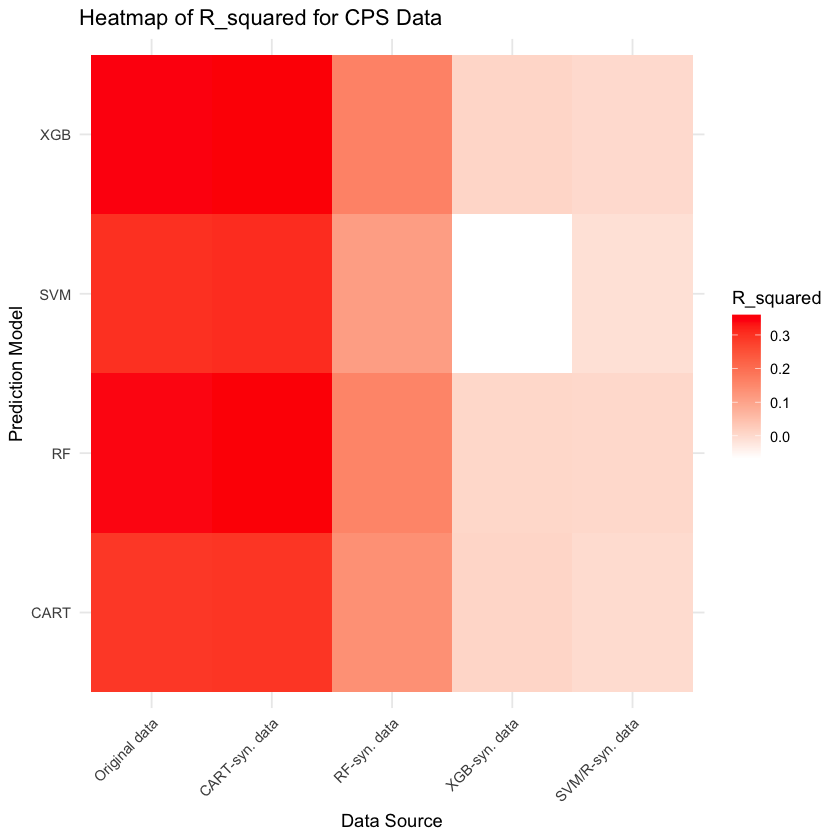

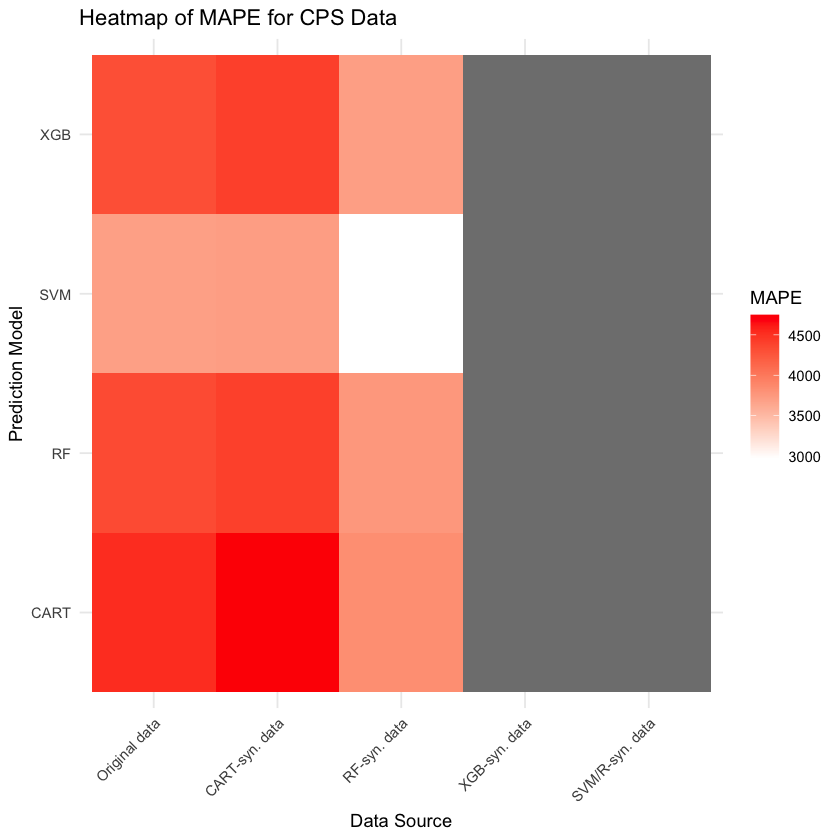

In [25]:
# CPS Data for heatmaps
cps_heatmap_data <- cps_table

# Iterate over each metric in the cps data
for (metric in metrics_regression) {
  # Filter the table for the current metric
  metric_data <- cps_heatmap_data[cps_heatmap_data$Metric == metric, ]
  
  # Melt the data into long format for ggplot
  metric_data_melt <- melt(metric_data, id.vars = c("Prediction Model", "Metric"))
  
  # Create the heatmap
  p <- ggplot(metric_data_melt, aes(x = variable, y = `Prediction Model`, fill = as.numeric(value))) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "red", name = metric) +  # Set the name to the metric
    labs(title = paste("Heatmap of", metric, "for CPS Data"), x = "Data Source", y = "Prediction Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for better readability
  
  # Print the heatmap
  print(p)
}


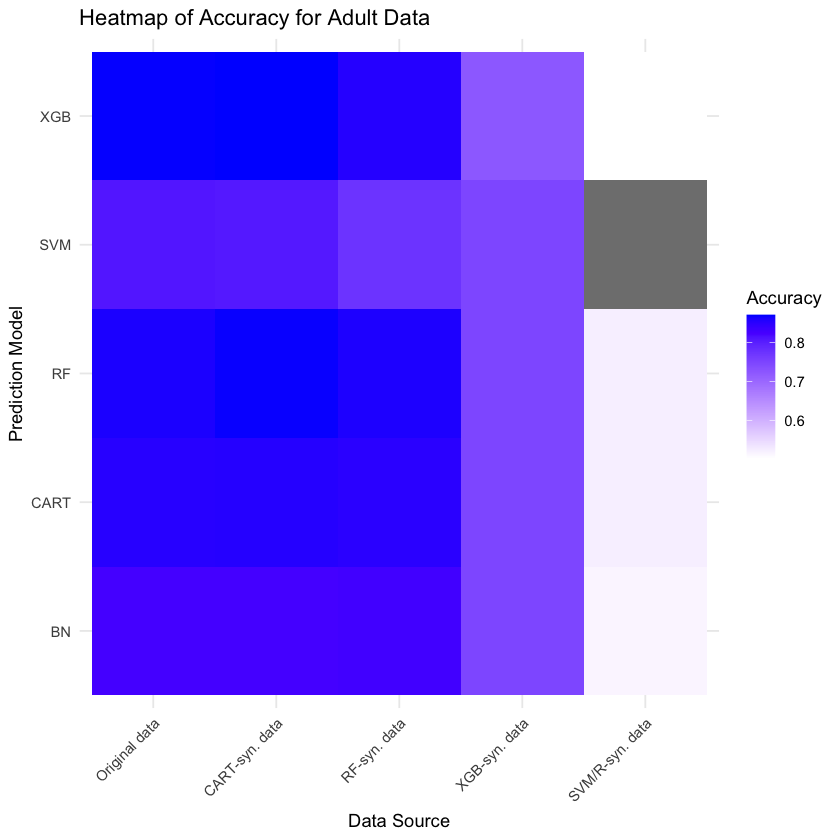

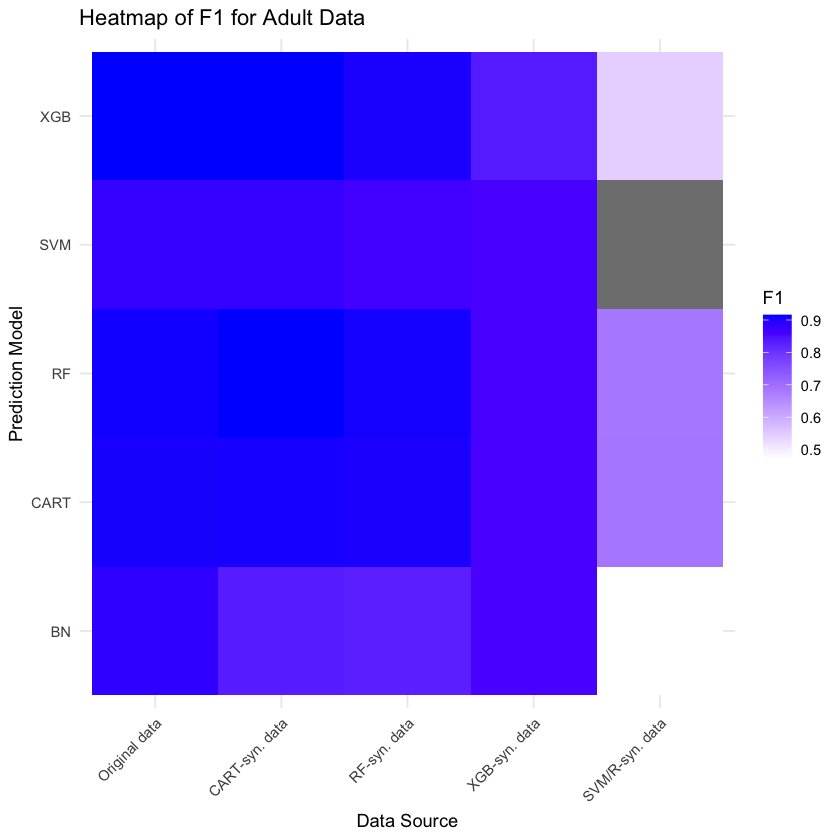

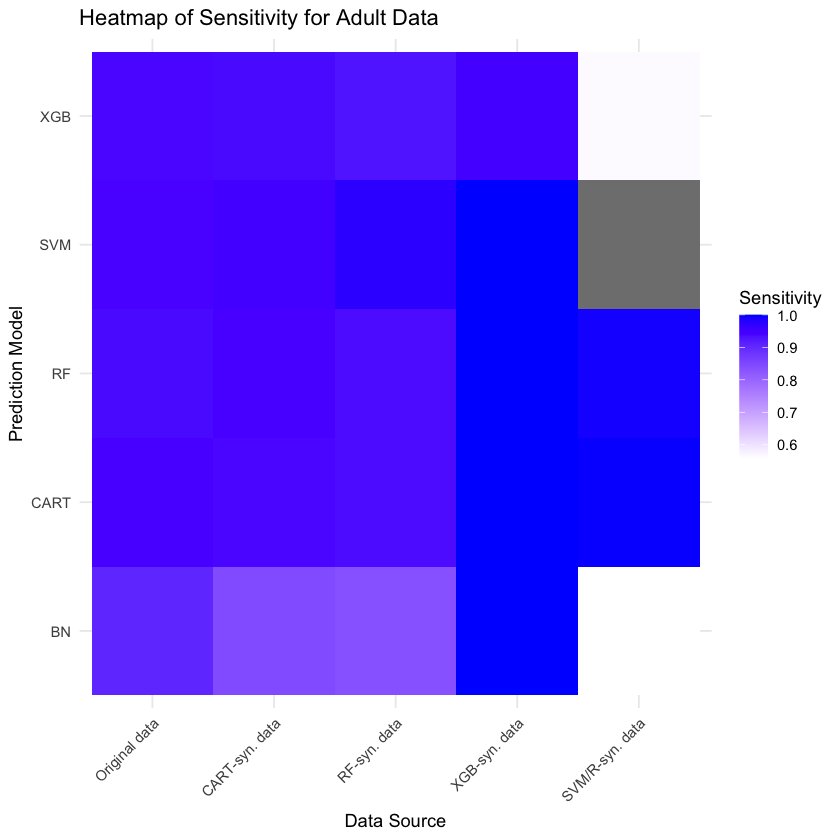

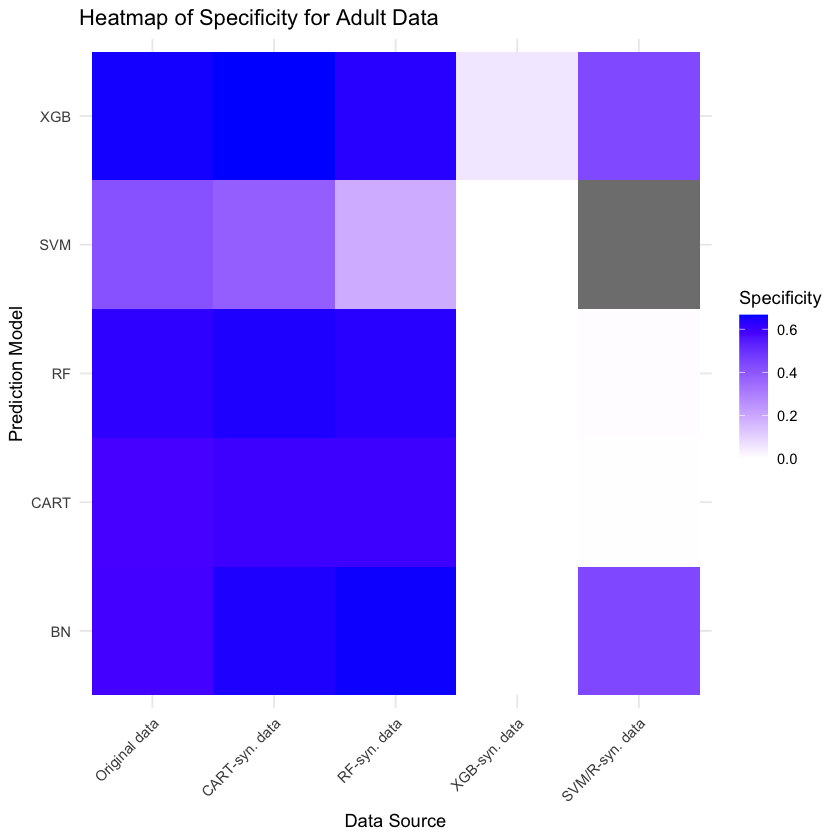

In [26]:
# Adult Data for heatmaps
adult_heatmap_data <- adult_table

# Iterate over each metric in the adult data
for (metric in metrics_classification) {
  # Filter the table for the current metric
  metric_data <- adult_heatmap_data[adult_heatmap_data$Metric == metric, ]
  
  # Melt the data into long format for ggplot
  metric_data_melt <- melt(metric_data, id.vars = c("Prediction Model", "Metric"))
  
  # Create the heatmap
  p <- ggplot(metric_data_melt, aes(x = variable, y = `Prediction Model`, fill = as.numeric(value))) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "blue", name = metric) +  # Set the name to the metric
    labs(title = paste("Heatmap of", metric, "for Adult Data"), x = "Data Source", y = "Prediction Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for better readability
  
  # Print the heatmap
  print(p)
}


## Prediction on Original data

### CPS orig

In [27]:
cps_og <- averaged_data[["cps_og"]]
(cps_og <- cps_og[, !colnames(cps_og) %in% "MAPE"])


,MAE,MSE,RMSE,R_squared
,<dbl>,<dbl>,<dbl>,<dbl>
CART,26343.33,1714859597,41407.16,0.2916392
RF,25034.96,1595924954,39942.33,0.3408800
XGB,24831.14,1583878594,39790.27,0.3459001
SVM,24080.63,1689493174,41097.85,0.3022338


In [28]:
options(scipen = 999)

In [29]:
# convert the relevant columns back to numeric if needed, then round them
cps_og$MAE <- as.numeric(cps_og$MAE)
cps_og$MSE <- as.numeric(cps_og$MSE)
cps_og$RMSE <- as.numeric(cps_og$RMSE)
cps_og$R_squared <- as.numeric(cps_og$R_squared)

cps_og[] <- lapply(cps_og, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 4, nsmall = 4) # 4 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframe to xtable
xtable_cps_og <- xtable(cps_og, 
                              caption = "CPS Original Data Prediction Metrics", 
                              label = "tab:cps_orig")

# Print the xtable with the desired formatting
print(xtable_cps_og, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:11 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 26343.3260 & 1714859596.8643 & 41407.1578 & 0.2916 \\ 
  RF & 25034.9584 & 1595924953.7000 & 39942.3272 & 0.3409 \\ 
  XGB & 24831.1398 & 1583878594.2573 & 39790.2731 & 0.3459 \\ 
  SVM & 24080.6321 & 1689493173.7316 & 41097.8532 & 0.3022 \\ 
   \hline
\end{tabular}
\caption{CPS Original Data Prediction Metrics} 
\label{tab:cps_orig}
\end{table}


### Adult orig

In [30]:
adult_og <- averaged_data[["adult_og"]]
(adult_og <- adult_og[rownames(adult_og) != "BN", ])


,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.8534414,0.9062172,0.9427518,0.5839644
RF,0.8608482,0.9101478,0.9383376,0.6270382
XGB,0.8689708,0.9150572,0.9396884,0.6555945
SVM,0.8107187,0.8825387,0.9416128,0.4157693


In [31]:
# Format all numeric columns to 4 decimal places
adult_og[] <- lapply(adult_og, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 4, nsmall = 4) # 4 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframe to xtable
xtable_adult_og <- xtable(adult_og, 
                            caption = "Adult Original Data Prediction Metrics", 
                            label = "tab:adult_orig")

# Print the xtable without rounding
print(xtable_adult_og, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:11 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8534 & 0.9062 & 0.9428 & 0.5840 \\ 
  RF & 0.8608 & 0.9101 & 0.9383 & 0.6270 \\ 
  XGB & 0.8690 & 0.9151 & 0.9397 & 0.6556 \\ 
  SVM & 0.8107 & 0.8825 & 0.9416 & 0.4158 \\ 
   \hline
\end{tabular}
\caption{Adult Original Data Prediction Metrics} 
\label{tab:adult_orig}
\end{table}


### CPS discretized orig

In [32]:
rownames(averaged_data[["cps_orig_dis_bn_pred"]]) <- "BN"
(cps_orig_dis <- rbind(averaged_data[["cps_orig_dis"]], averaged_data[["cps_orig_dis_bn_pred"]]))

,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.9603791,0.9797912,0.2199971,0.8000166
RF,0.9603932,0.9797965,0.2200000,0.8000000
XGB,0.9604114,0.9019285,0.2201137,0.8000919
SVM,0.9603932,0.9797965,0.2200000,0.8000000
BN,0.9603940,0.9797969,0.2200000,0.8000000


In [33]:
cps_orig_dis[] <- lapply(cps_orig_dis, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 4, nsmall = 4) # 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert the dataframe to an xtable
xtable_cps_orig_dis <- xtable(cps_orig_dis, 
                              caption = "CPS Original Data Prediction Metrics", 
                              label = "tab:cps_orig_dis")

# Print the xtable without rounding
print(xtable_cps_orig_dis, include.rownames = TRUE, sanitize.text.function = identity)

% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:11 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.9604 & 0.9798 & 0.2200 & 0.8000 \\ 
  RF & 0.9604 & 0.9798 & 0.2200 & 0.8000 \\ 
  XGB & 0.9604 & 0.9019 & 0.2201 & 0.8001 \\ 
  SVM & 0.9604 & 0.9798 & 0.2200 & 0.8000 \\ 
  BN & 0.9604 & 0.9798 & 0.2200 & 0.8000 \\ 
   \hline
\end{tabular}
\caption{CPS Original Data Prediction Metrics} 
\label{tab:cps_orig_dis}
\end{table}


### Adult discretized orig

In [34]:
(adult_orig_dis <- averaged_data[["adult_orig_dis"]])

,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.8316757,0.8916508,0.9221991,0.5585375
RF,0.8371926,0.8951397,0.9252052,0.5716326
XGB,0.8431968,0.8981551,0.9205837,0.6096967
SVM,0.8152872,0.8833293,0.9305817,0.4674074
BN,0.8262161,0.8866629,0.9053639,0.5876945


In [35]:
# Extract the 'adult_orig_dis' dataframe
adult_orig_dis <- averaged_data[["adult_orig_dis"]]

adult_orig_dis[] <- lapply(adult_orig_dis, function(x) {
  if(is.numeric(x)) {
    format(x, digits = 4, nsmall = 4) # 4 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert the dataframe to an xtable
xtable_adult_orig_dis <- xtable(adult_orig_dis, 
                                caption = "Adult Discretized Data Prediction Metrics", 
                                label = "tab:adult_orig_dis")

# Print the xtable without rounding
print(xtable_adult_orig_dis, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:11 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8317 & 0.8917 & 0.9222 & 0.5585 \\ 
  RF & 0.8372 & 0.8951 & 0.9252 & 0.5716 \\ 
  XGB & 0.8432 & 0.8982 & 0.9206 & 0.6097 \\ 
  SVM & 0.8153 & 0.8833 & 0.9306 & 0.4674 \\ 
  BN & 0.8262 & 0.8867 & 0.9054 & 0.5877 \\ 
   \hline
\end{tabular}
\caption{Adult Discretized Data Prediction Metrics} 
\label{tab:adult_orig_dis}
\end{table}


## Prediction on CART data

In [36]:
# Extract the dataframes from averaged_data
cps_cart <- averaged_data[["cps_cart"]]
adult_cart <- averaged_data[["adult_cart"]]

# Filter out BN row and MAPE column
adult_cart <- adult_cart[rownames(adult_cart) != "BN", ]
cps_cart <- cps_cart[, !colnames(cps_cart) %in% "MAPE"]

# Format all numeric columns to 7 decimal places
cps_cart[] <- lapply(cps_cart, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Format all numeric columns to 7 decimal places
adult_cart[] <- lapply(adult_cart, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 7, nsmall = 7) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframes to xtable
xtable_cps_cart <- xtable(cps_cart, 
                          caption = "CPS CART-Synthesized Data Prediction Metrics", 
                          label = "tab:cps_cart")

xtable_adult_cart <- xtable(adult_cart, 
                            caption = "Adult CART-Synthesized Data Prediction Metrics", 
                            label = "tab:adult_cart")

# Print the xtables without rounding
print(xtable_cps_cart, include.rownames = TRUE, sanitize.text.function = identity)
print(xtable_adult_cart, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:11 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 26178.4902695 & 1705863260.3988602 & 41289.5052688 & 0.2952757 \\ 
  RF & 24540.4966460 & 1549769835.4098353 & 39356.3951169 & 0.3597545 \\ 
  XGB & 24510.8488644 & 1549601719.9055719 & 39355.7747158 & 0.3597220 \\ 
  SVM & 23928.5528633 & 1676849659.6953473 & 40938.4980827 & 0.3072423 \\ 
   \hline
\end{tabular}
\caption{CPS CART-Synthesized Data Prediction Metrics} 
\label{tab:cps_cart}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:11 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8546714 & 0.9065522 & 0.9398256 & 0.5989968 \\ 
  RF & 0.8685068 & 0.9148870 & 0.9421881 & 0.6473191 \\ 
  XGB & 0.8706121 & 0.9158385 & 0.9386075 & 0.6665026 \\ 
  SVM & 0.8080343 & 

with differences included

In [37]:
# Ensure the original data rows match the synthetic data columns
cps_og <- cps_og[, colnames(cps_cart)]
adult_og <- adult_og[, colnames(adult_cart)]

# Initialize empty lists to store updated dataframes
cps_cart_with_diff <- list()
adult_cart_with_diff <- list()

# Function to add the difference rows for each model
add_difference_rows <- function(model_data, original_data) {
  updated_data <- data.frame()  # Initialize an empty dataframe to store the rows and differences
  
  for (model in rownames(model_data)) {
    # Get the original and synthetic data rows for the current model
    synthetic_row <- as.numeric(model_data[model, ])
    original_row <- as.numeric(original_data[model, ])
    
    # Compute the difference
    diff_row <- synthetic_row - original_row
    
    # Create dataframes for the synthetic and difference rows
    synthetic_row_df <- data.frame(t(synthetic_row), check.names = FALSE)
    diff_row_df <- data.frame(t(diff_row), check.names = FALSE)
    
    # Set the column names for both rows to match the original dataframe
    colnames(synthetic_row_df) <- colnames(model_data)
    colnames(diff_row_df) <- colnames(model_data)
    
    # Name the rows accordingly, using a space instead of an underscore
    rownames(synthetic_row_df) <- model
    rownames(diff_row_df) <- paste(model, "Diff.")
    
    # Add the synthetic row and its difference to the updated dataframe
    updated_data <- rbind(updated_data, synthetic_row_df, diff_row_df)
  }
  
  return(updated_data)
}

# Apply the function to both cps and adult data
cps_cart_with_diff <- add_difference_rows(cps_cart, cps_og)
adult_cart_with_diff <- add_difference_rows(adult_cart, adult_og)

# Format columns with different decimal places for cps_cart_with_diff
cps_cart_with_diff[] <- lapply(names(cps_cart_with_diff), function(col) {
  if (col %in% c("MAE", "MSE", "RMSE")) {
    format(round(as.numeric(cps_cart_with_diff[[col]]), 2), nsmall = 2) # 2 decimal places
  } else if (col == "R_squared") {
    format(round(as.numeric(cps_cart_with_diff[[col]]), 4), nsmall = 4) # 4 decimal places
  } else {
    cps_cart_with_diff[[col]] # Non-numeric columns remain unchanged
  }
})

# Format all numeric columns in adult_cart_with_diff to 4 decimal places
adult_cart_with_diff[] <- lapply(adult_cart_with_diff, function(x) {
  if (is.numeric(x)) {
    format(round(x, digits = 4), nsmall = 4) # Ensure 4 decimal places
  } else {
    x # Non-numeric columns remain unchanged
  }
})

# Convert dataframes to xtable with case-sensitive captions
xtable_cps_cart <- xtable(cps_cart_with_diff, 
                          caption = "CPS CART-synth. data: prediction metrics and difference to original data", 
                          label = "tab:cps_cart")

xtable_adult_cart <- xtable(adult_cart_with_diff, 
                            caption = "Adult CART-synth. data: prediction metrics and difference to original data", 
                            label = "tab:adult_cart")

# Print the xtables without rounding, preserving case-sensitivity in captions
print(xtable_cps_cart, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")
print(xtable_adult_cart, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:12 2024
\begin{table}[ht]
\centering
\caption{CPS CART-synth. data: prediction metrics and difference to original data} 
\label{tab:cps_cart}
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 26178.49 & 1705863260.40 & 41289.51 & 0.2953 \\ 
  CART Diff. &  -164.84 &   -8996336.47 &  -117.65 & 0.0037 \\ 
  RF & 24540.50 & 1549769835.41 & 39356.40 & 0.3598 \\ 
  RF Diff. &  -494.46 &  -46155118.29 &  -585.93 & 0.0189 \\ 
  XGB & 24510.85 & 1549601719.91 & 39355.77 & 0.3597 \\ 
  XGB Diff. &  -320.29 &  -34276874.35 &  -434.50 & 0.0138 \\ 
  SVM & 23928.55 & 1676849659.70 & 40938.50 & 0.3072 \\ 
  SVM Diff. &  -152.08 &  -12643514.04 &  -159.36 & 0.0050 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:12 2024
\begin{table}[ht]
\centering
\caption{Adult CART-synth. data: prediction metrics and difference to orig

## Prediction on RF data

In [38]:
# Extract the dataframes from averaged_data
cps_rf <- averaged_data[["cps_rf"]]
adult_rf <- averaged_data[["adult_rf"]]

cps_rf <- cps_rf[, colnames(cps_rf) != "MAPE"]
adult_rf <- adult_rf[rownames(adult_rf) != "BN", ]

In [39]:
# Remove the "MAPE" column from cps_rf to match columns with cps_og
cps_rf <- cps_rf[, colnames(cps_rf) != "MAPE"]

# Ensure the original data rows match the synthetic data columns
cps_og <- cps_og[, colnames(cps_rf)]
adult_og <- adult_og[, colnames(adult_rf)]

# Initialize empty lists to store updated dataframes
cps_rf_with_diff <- list()
adult_rf_with_diff <- list()

# Function to add the difference rows for each model
add_difference_rows <- function(model_data, original_data) {
  updated_data <- data.frame()  # Initialize an empty dataframe to store the rows and differences
  
  for (model in rownames(model_data)) {
    # Get the original and synthetic data rows for the current model
    synthetic_row <- as.numeric(model_data[model, ])
    original_row <- as.numeric(original_data[model, ])
    
    # Compute the difference
    diff_row <- synthetic_row - original_row
    
    # Create dataframes for the synthetic and difference rows
    synthetic_row_df <- data.frame(t(synthetic_row), check.names = FALSE)
    diff_row_df <- data.frame(t(diff_row), check.names = FALSE)
    
    # Set the column names for both rows to match the original dataframe
    colnames(synthetic_row_df) <- colnames(model_data)
    colnames(diff_row_df) <- colnames(model_data)
    
    # Name the rows accordingly, using a space instead of an underscore
    rownames(synthetic_row_df) <- model
    rownames(diff_row_df) <- paste(model, "Diff.")
    
    # Add the synthetic row and its difference to the updated dataframe
    updated_data <- rbind(updated_data, synthetic_row_df, diff_row_df)
  }
  
  return(updated_data)
}

# Apply the function to both cps and adult RF data
cps_rf_with_diff <- add_difference_rows(cps_rf, cps_og)
adult_rf_with_diff <- add_difference_rows(adult_rf, adult_og)

# Format specific columns with different decimal places in cps_rf_with_diff
cps_rf_with_diff[] <- lapply(names(cps_rf_with_diff), function(col) {
  if (col %in% c("MAE", "MSE", "RMSE")) {
    format(round(as.numeric(cps_rf_with_diff[[col]]), 2), nsmall = 2) # 2 decimal places
  } else if (col == "R_squared") {
    format(round(as.numeric(cps_rf_with_diff[[col]]), 4), nsmall = 4) # 4 decimal places
  } else {
    cps_rf_with_diff[[col]] # Non-numeric columns remain unchanged
  }
})

# Format all numeric columns in adult_rf_with_diff to 4 decimal places
adult_rf_with_diff[] <- lapply(adult_rf_with_diff, function(x) {
  if (is.numeric(x)) {
    format(round(x, digits = 4), nsmall = 4) # Ensure 4 decimal places
  } else {
    x # Non-numeric columns remain unchanged
  }
})

# Convert dataframes to xtable with case-sensitive captions
xtable_cps_rf <- xtable(cps_rf_with_diff, 
                          caption = "CPS RF-synthesized data: prediction metrics and difference to original data", 
                          label = "tab:cps_rf")

xtable_adult_rf <- xtable(adult_rf_with_diff, 
                            caption = "Adult RF-synthesized data: prediction metrics with difference to original data", 
                            label = "tab:adult_rf")

# Print the xtables without rounding, preserving case-sensitivity in captions
print(xtable_cps_rf, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")
print(xtable_adult_rf, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:12 2024
\begin{table}[ht]
\centering
\caption{CPS RF-synthesized data: prediction metrics and difference to original data} 
\label{tab:cps_rf}
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 29679.63 & 2049007653.39 & 45256.92 &  0.1365 \\ 
  CART Diff. &  3336.31 &  334148056.52 &  3849.76 & -0.1551 \\ 
  RF & 29138.62 & 1996587550.42 & 44670.70 &  0.1587 \\ 
  RF Diff. &  4103.66 &  400662596.72 &  4728.37 & -0.1822 \\ 
  XGB & 28986.37 & 1988414595.86 & 44579.56 &  0.1621 \\ 
  XGB Diff. &  4155.23 &  404536001.61 &  4789.28 & -0.1838 \\ 
  SVM & 27906.29 & 2106843603.44 & 45892.21 &  0.1122 \\ 
  SVM Diff. &  3825.66 &  417350429.71 &  4794.36 & -0.1900 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:12 2024
\begin{table}[ht]
\centering
\caption{Adult RF-synthesized data: prediction metrics with diffe

## Prediction on XGB data

In [40]:
# Extract the dataframes from averaged_data
cps_xgb <- averaged_data[["cps_xgb"]]
adult_xgb <- averaged_data[["adult_xgb"]]
cps_xgb <- cps_xgb[, colnames(cps_xgb) != "MAPE"]
adult_xgb <- adult_xgb[rownames(adult_xgb) != "BN", ]

In [41]:
# Ensure the original data rows match the synthetic data columns
cps_og <- cps_og[, colnames(cps_xgb)]
adult_og <- adult_og[, colnames(adult_xgb)]

# Initialize empty lists to store updated dataframes
cps_xgb_with_diff <- list()
adult_xgb_with_diff <- list()

# Function to add the difference rows for each model
add_difference_rows <- function(model_data, original_data) {
  updated_data <- data.frame()  # Initialize an empty dataframe to store the rows and differences
  
  for (model in rownames(model_data)) {
    # Get the original and synthetic data rows for the current model
    synthetic_row <- as.numeric(model_data[model, ])
    original_row <- as.numeric(original_data[model, ])
    
    # Compute the difference
    diff_row <- synthetic_row - original_row
    
    # Create dataframes for the synthetic and difference rows
    synthetic_row_df <- data.frame(t(synthetic_row), check.names = FALSE)
    diff_row_df <- data.frame(t(diff_row), check.names = FALSE)
    
    # Set the column names for both rows to match the original dataframe
    colnames(synthetic_row_df) <- colnames(model_data)
    colnames(diff_row_df) <- colnames(model_data)
    
    # Name the rows accordingly, using a space instead of an underscore
    rownames(synthetic_row_df) <- model
    rownames(diff_row_df) <- paste(model, "Diff.")
    
    # Add the synthetic row and its difference to the updated dataframe
    updated_data <- rbind(updated_data, synthetic_row_df, diff_row_df)
  }
  
  return(updated_data)
}

# Apply the function to both cps and adult data
cps_xgb_with_diff <- add_difference_rows(cps_xgb, cps_og)
adult_xgb_with_diff <- add_difference_rows(adult_xgb, adult_og)

# Format specific columns with different decimal places in cps_xgb_with_diff
cps_xgb_with_diff[] <- lapply(names(cps_xgb_with_diff), function(col) {
  if (col %in% c("MAE", "MSE", "RMSE")) {
    format(round(as.numeric(cps_xgb_with_diff[[col]]), 2), nsmall = 2) # 2 decimal places
  } else if (col == "R_squared") {
    format(round(as.numeric(cps_xgb_with_diff[[col]]), 4), nsmall = 4) # 4 decimal places
  } else {
    cps_xgb_with_diff[[col]] # Non-numeric columns remain unchanged
  }
})

# Format all numeric columns in adult_xgb_with_diff to 4 decimal places
adult_xgb_with_diff[] <- lapply(adult_xgb_with_diff, function(x) {
  if (is.numeric(x)) {
    format(round(x, digits = 4), nsmall = 4) # Ensure 4 decimal places
  } else {
    x # Non-numeric columns remain unchanged
  }
})

# Convert dataframes to xtable with case-sensitive captions
xtable_cps_xgb <- xtable(cps_xgb_with_diff, 
                          caption = "CPS XGB-synth. data: prediction metrics and difference to original data", 
                          label = "tab:cps_xgb")

xtable_adult_xgb <- xtable(adult_xgb_with_diff, 
                            caption = "Adult XGB-synth. data: prediction metrics and difference to original data", 
                            label = "tab:adult_xgb")

# Print the xtables without rounding, preserving case-sensitivity in captions
print(xtable_cps_xgb, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")
print(xtable_adult_xgb, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:12 2024
\begin{table}[ht]
\centering
\caption{CPS XGB-synth. data: prediction metrics and difference to original data} 
\label{tab:cps_xgb}
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 33607.18 & 2404325889.05 & 49024.05 &  0.0079 \\ 
  CART Diff. &  7263.85 &  689466292.18 &  7616.90 & -0.2837 \\ 
  RF & 33686.01 & 2410918011.79 & 49093.20 &  0.0052 \\ 
  RF Diff. &  8651.05 &  814993058.09 &  9150.88 & -0.3357 \\ 
  XGB & 33615.57 & 2400645692.00 & 48988.35 &  0.0093 \\ 
  XGB Diff. &  8784.43 &  816767097.74 &  9198.08 & -0.3366 \\ 
  SVM & 31962.07 & 2586428611.78 & 50850.02 & -0.0672 \\ 
  SVM Diff. &  7881.44 &  896935438.05 &  9752.17 & -0.3694 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:12 2024
\begin{table}[ht]
\centering
\caption{Adult XGB-synth. data: prediction metrics and difference to

## Prediction on SVM data

In [42]:
# load SVM pred results on SVM-synth. adult data
file_names <- paste0(here(), "/results/adult_svm_eval_", 1235:1244, ".RData")

# initialize
data_list <- list()

for (file in file_names) {
  load(file)
  data_list[[file]] <- svm_eval
}

# average for each element in the list of dataframes
avg_adult_svm <- Reduce("+", data_list) / length(data_list)
rownames(avg_adult_svm) <- "SVM"
print(avg_adult_svm)

     Accuracy       F1 Sensitivity Specificity
SVM 0.5237915 0.687215   0.9984448 0.001338043


In [43]:
# Extract the dataframes from averaged_data
cps_svm <- averaged_data[["cps_svm"]]
cps_svm <- cps_svm[, colnames(cps_svm) != "MAPE"]
adult_svm <- averaged_data[["adult_svm"]]
adult_svm <- adult_svm[rownames(adult_svm) != "BN", ]
adult_svm <- rbind(adult_svm, avg_adult_svm)
adult_svm

,Accuracy,F1,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>,<dbl>
CART,0.5234990,0.6867096,0.9976028,0.002445391
RF,0.5230975,0.6854309,0.9927806,0.006866104
XGB,0.5036176,0.5437931,0.5651124,0.435979948
SVM,0.5237915,0.6872150,0.9984448,0.001338043


In [44]:
# Ensure the original data rows match the synthetic data columns
cps_og <- cps_og[, colnames(cps_svm)]
adult_og <- adult_og[, colnames(adult_svm)]

# Initialize empty lists to store updated dataframes
cps_svm_with_diff <- list()
adult_svm_with_diff <- list()

# Function to add the difference rows for each model
add_difference_rows <- function(model_data, original_data) {
  updated_data <- data.frame()  # Initialize an empty dataframe to store the rows and differences
  
  for (model in rownames(model_data)) {
    # Get the original and synthetic data rows for the current model
    synthetic_row <- as.numeric(model_data[model, ])
    original_row <- as.numeric(original_data[model, ])
    
    # Compute the difference
    diff_row <- synthetic_row - original_row
    
    # Create dataframes for the synthetic and difference rows
    synthetic_row_df <- data.frame(t(synthetic_row), check.names = FALSE)
    diff_row_df <- data.frame(t(diff_row), check.names = FALSE)
    
    # Set the column names for both rows to match the original dataframe
    colnames(synthetic_row_df) <- colnames(model_data)
    colnames(diff_row_df) <- colnames(model_data)
    
    # Name the rows accordingly, using "Diff." for the difference row
    rownames(synthetic_row_df) <- model
    rownames(diff_row_df) <- paste(model, "Diff.")
    
    # Add the synthetic row and its difference to the updated dataframe
    updated_data <- rbind(updated_data, synthetic_row_df, diff_row_df)
  }
  
  return(updated_data)
}

# Apply the function to both cps and adult SVM data
cps_svm_with_diff <- add_difference_rows(cps_svm, cps_og)
adult_svm_with_diff <- add_difference_rows(adult_svm, adult_og)

# Format specific columns with different decimal places in cps_svm_with_diff
cps_svm_with_diff[] <- lapply(names(cps_svm_with_diff), function(col) {
  if (col %in% c("MAE", "MSE", "RMSE")) {
    format(round(as.numeric(cps_svm_with_diff[[col]]), 2), nsmall = 2) # 2 decimal places
  } else if (col == "R_squared") {
    format(round(as.numeric(cps_svm_with_diff[[col]]), 4), nsmall = 4) # 4 decimal places
  } else {
    cps_svm_with_diff[[col]] # Non-numeric columns remain unchanged
  }
})

# Format all numeric columns in adult_svm_with_diff to 4 decimal places
adult_svm_with_diff[] <- lapply(adult_svm_with_diff, function(x) {
  if (is.numeric(x)) {
    format(round(x, digits = 4), nsmall = 4) # Ensure 4 decimal places
  } else {
    x # Non-numeric columns remain unchanged
  }
})

# Convert dataframes to xtable with case-sensitive captions
xtable_cps_svm <- xtable(cps_svm_with_diff, 
                          caption = "CPS SVM-synth. data: prediction metrics and difference to original data", 
                          label = "tab:cps_svm")

xtable_adult_svm <- xtable(adult_svm_with_diff, 
                            caption = "Adult SVM-synth. data: prediction metrics and difference to original data", 
                            label = "tab:adult_svm")

# Print the xtables without rounding, preserving case-sensitivity in captions
print(xtable_cps_svm, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")
print(xtable_adult_svm, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:13 2024
\begin{table}[ht]
\centering
\caption{CPS SVM-synth. data: prediction metrics and difference to original data} 
\label{tab:cps_svm}
\begin{tabular}{rllll}
  \hline
 & MAE & MSE & RMSE & R_squared \\ 
  \hline
CART & 1348450909741666.75 & 25787733877617966337278074683392.00 & 4971040554279611.00 & -0.0025 \\ 
  CART Diff. & 1348450909715323.50 & 25787733877617966337278074683392.00 & 4971040554238204.00 & -0.2941 \\ 
  RF & 1347339093216365.50 & 25671609342647586379224156471296.00 & 4960469480837069.00 &  0.0019 \\ 
  RF Diff. & 1347339093191330.50 & 25671609342647586379224156471296.00 & 4960469480797127.00 & -0.3390 \\ 
  XGB & 1348951287810317.50 & 25701270621887425002212291510272.00 & 4964808779946628.00 &  0.0009 \\ 
  XGB Diff. & 1348951287785486.25 & 25701270621887425002212291510272.00 & 4964808779906838.00 & -0.3450 \\ 
  SVM & 1060587718397631.25 & 25970900054582098065180774629376.00 & 497450107

## Prediction on BN data

In [45]:
# Extract the dataframes from averaged_data
cps_bn <- rbind(averaged_data[["cps_bn"]], averaged_data[["cps_bn_bn_pred"]])
rownames(cps_bn)[nrow(cps_bn)] <- "BN"
adult_bn <- averaged_data[["adult_bn"]]

# Format all numeric columns to 7 decimal places
cps_bn[] <- lapply(cps_bn, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 4, nsmall = 4) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Format all numeric columns to 7 decimal places
adult_bn[] <- lapply(adult_bn, function(x) {
  if (is.numeric(x)) {
    format(x, digits = 4, nsmall = 4) # Retain 7 decimal places
  } else {
    x # Non-numeric columns are left unchanged
  }
})

# Convert dataframes to xtable
xtable_cps_bn <- xtable(cps_bn, 
                        caption = "CPS BN-Synthesized Data Prediction Metrics", 
                        label = "tab:cps_bn")

xtable_adult_bn <- xtable(adult_bn, 
                          caption = "Adult BN-Synthesized Data Prediction Metrics", 
                          label = "tab:adult_bn")

# Print the xtables without rounding
print(xtable_cps_bn, include.rownames = TRUE, sanitize.text.function = identity)
print(xtable_adult_bn, include.rownames = TRUE, sanitize.text.function = identity)


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:13 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.9600 & 0.9796 & 0.2190 & 0.8000 \\ 
  RF & 0.9600 & 0.9699 & 0.2190 & 0.8000 \\ 
  XGB & 0.9600 & 0.9699 & 0.2190 & 0.8000 \\ 
  SVM & 0.9600 & 0.9796 & 0.2190 & 0.8000 \\ 
  BN & 0.9600 & 0.9796 & 0.2190 & 0.8000 \\ 
   \hline
\end{tabular}
\caption{CPS BN-Synthesized Data Prediction Metrics} 
\label{tab:cps_bn}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:13 2024
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART & 0.8344 & 0.8946 & 0.9300 & 0.5393 \\ 
  RF & 0.8365 & 0.8959 & 0.9313 & 0.5438 \\ 
  XGB & 0.8421 & 0.8988 & 0.9289 & 0.5737 \\ 
  SVM & 0.8185 & 0.8869 & 0.9404 & 0.4423 \\ 
  BN & 0.8430 & 0.8478 & 0.8561 & 0.6564 \\ 
   \hline
\end{tabular}
\ca

In [46]:
# Initialize empty dataframes to store updated CPS and Adult BN data
cps_bn_with_diff <- data.frame()
adult_bn_with_diff <- data.frame()

# Function to add the difference rows for each model
add_difference_rows <- function(synthetic_data, original_data) {
  updated_data <- data.frame()  # Initialize an empty dataframe to store the rows and differences
  
  for (model in rownames(synthetic_data)) {
    # Get the original and synthetic data rows for the current model
    synthetic_row <- as.numeric(synthetic_data[model, ])
    original_row <- as.numeric(original_data[model, ])
    
    # Compute the difference
    diff_row <- synthetic_row - original_row
    
    # Create dataframes for the synthetic and difference rows
    synthetic_row_df <- data.frame(t(synthetic_row), check.names = FALSE)
    diff_row_df <- data.frame(t(diff_row), check.names = FALSE)
    
    # Set the column names for both rows to match the original dataframe
    colnames(synthetic_row_df) <- colnames(synthetic_data)
    colnames(diff_row_df) <- colnames(synthetic_data)
    
    # Name the rows accordingly, using "Diff." for the difference row
    rownames(synthetic_row_df) <- model
    rownames(diff_row_df) <- paste(model, "Diff.")
    
    # Add the synthetic row and its difference to the updated dataframe
    updated_data <- rbind(updated_data, synthetic_row_df, diff_row_df)
  }
  
  return(updated_data)
}

# Apply the function to both cps_bn and adult_bn data using their original counterparts
cps_bn_with_diff <- add_difference_rows(cps_bn, cps_orig_dis)
adult_bn_with_diff <- add_difference_rows(adult_bn, adult_orig_dis)

# Format numeric columns in cps_bn_with_diff to 7 decimal places
cps_bn_with_diff[] <- lapply(cps_bn_with_diff, function(x) {
  if (is.numeric(x)) {
    format(round(as.numeric(x), digits = 4), nsmall = 4)
  } else {
    x
  }
})

# Format numeric columns in adult_bn_with_diff to 7 decimal places
adult_bn_with_diff[] <- lapply(adult_bn_with_diff, function(x) {
  if (is.numeric(x)) {
    format(round(as.numeric(x), digits = 4), nsmall = 4)
  } else {
    x
  }
})

# Convert dataframes to xtable with appropriate captions
xtable_cps_bn <- xtable(cps_bn_with_diff, 
                        caption = "CPS BN-Synthesized Data Prediction Metrics and Differences to Original Data", 
                        label = "tab:cps_bn")

xtable_adult_bn <- xtable(adult_bn_with_diff, 
                          caption = "Adult BN-Synthesized Data Prediction Metrics and Differences to Original Data", 
                          label = "tab:adult_bn")

# Print the xtables without rounding
print(xtable_cps_bn, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")
print(xtable_adult_bn, include.rownames = TRUE, sanitize.text.function = identity, caption.placement = "top")


% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:13 2024
\begin{table}[ht]
\centering
\caption{CPS BN-Synthesized Data Prediction Metrics and Differences to Original Data} 
\label{tab:cps_bn}
\begin{tabular}{rllll}
  \hline
 & Accuracy & F1 & Sensitivity & Specificity \\ 
  \hline
CART &  0.9600 &  0.9796 &  0.2190 &  0.8000 \\ 
  CART Diff. & -0.0004 & -0.0002 & -0.0010 &  0.0000 \\ 
  RF &  0.9600 &  0.9699 &  0.2190 &  0.8000 \\ 
  RF Diff. & -0.0004 & -0.0099 & -0.0010 &  0.0000 \\ 
  XGB &  0.9600 &  0.9699 &  0.2190 &  0.8000 \\ 
  XGB Diff. & -0.0004 &  0.0680 & -0.0011 & -0.0001 \\ 
  SVM &  0.9600 &  0.9796 &  0.2190 &  0.8000 \\ 
  SVM Diff. & -0.0004 & -0.0002 & -0.0010 &  0.0000 \\ 
  BN &  0.9600 &  0.9796 &  0.2190 &  0.8000 \\ 
  BN Diff. & -0.0004 & -0.0002 & -0.0010 &  0.0000 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Wed Oct 30 09:28:13 2024
\begin{table}[ht]
\centering
\caption{Adu

## Z-score normalisation for overall comparison

### single z-scores

In [47]:
# Initialize list with expected dataset names
dataset_names <- c("cps_og", "cps_cart", "cps_rf", "cps_xgb", "cps_svm", "cps_orig_dis", "cps_bn", 
                  "adult_og", "adult_cart", "adult_rf", "adult_xgb", "adult_svm", "adult_orig_dis","adult_bn")

# Check for each dataset, assigning NULL if it doesn't exist
datasets <- lapply(dataset_names, function(name) {
  if (exists(name)) {
    get(name)
  } else {
    NULL
  }
})
names(datasets) <- dataset_names  # Assign names to each list element

# Z-score normalization function with conversion to numeric
z_score_normalize <- function(df) {
  # Convert to numeric matrix while preserving row and column names
  df_numeric <- as.data.frame(lapply(df, as.numeric))
  rownames(df_numeric) <- rownames(df)
  colnames(df_numeric) <- colnames(df)
  
  # Apply z-score normalization to numeric values
  df_normalized <- apply(df_numeric, 2, function(column) {
    (column - mean(column, na.rm = TRUE)) / sd(column, na.rm = TRUE)
  })
  
  # Convert back to data frame to preserve structure
  df_normalized <- as.data.frame(df_normalized)
  rownames(df_normalized) <- rownames(df)
  colnames(df_normalized) <- colnames(df)
  
  return(df_normalized)
}

# Apply z-score normalization only to existing datasets
z_score_datasets <- lapply(datasets, function(df) {
  if (!is.null(df)) {
    z_score_normalize(df)
  } else {
    NULL  # Keep as NULL if the original dataset is missing
  }
})

# Assign names to normalized datasets with suffix "_z"
names(z_score_datasets) <- paste0(dataset_names, "_z")


In [48]:
z_score_datasets

,MAE,MSE,RMSE,R_squared
,<dbl>,<dbl>,<dbl>,<dbl>
CART,1.34997726,1.0454638,1.0432613,-1.0469448
RF,-0.03989521,-0.7612919,-0.7593835,0.7609143
XGB,-0.25641071,-0.9442902,-0.9465038,0.9442672
SVM,-1.05367135,0.6601183,0.6626260,-0.6582367
,MAE,MSE,RMSE,R_squared
,<dbl>,<dbl>,<dbl>,<dbl>
CART,1.4350364,1.0326125,1.0287435,-1.0324875
RF,-0.2573764,-0.8560678,-0.8572178,0.8575757
XGB,-0.2880092,-0.8581020,-0.8578231,0.8566231


### global z-scores

In [49]:
# define datasets
metrics_datasets <- list(
  MAE = c("cps_og", "cps_cart", "cps_rf", "cps_xgb", "cps_svm"),
  MSE = c("cps_og", "cps_cart", "cps_rf", "cps_xgb", "cps_svm"),
  RMSE = c("cps_og", "cps_cart", "cps_rf", "cps_xgb", "cps_svm"),
  R_squared = c("cps_og", "cps_cart", "cps_rf", "cps_xgb", "cps_svm"),
  Accuracy_cps = c("cps_orig_dis", "cps_bn"),
  F1_cps = c("cps_orig_dis", "cps_bn"),
  Sensitivity_cps = c("cps_orig_dis", "cps_bn"),
  Specificity_cps = c("cps_orig_dis", "cps_bn"),
  Accuracy_adult = c("adult_orig_dis", "adult_bn"),
  F1_adult = c("adult_orig_dis", "adult_bn"),
  Sensitivity_adult = c("adult_orig_dis", "adult_bn"),
  Specificity_adult = c("adult_orig_dis", "adult_bn"),
  Accuracy_adult_og = c("adult_og", "adult_cart", "adult_rf", "adult_xgb", "adult_svm"),
  F1_adult_og = c("adult_og", "adult_cart", "adult_rf", "adult_xgb", "adult_svm"),
  Sensitivity_adult_og = c("adult_og", "adult_cart", "adult_rf", "adult_xgb", "adult_svm"),
  Specificity_adult_og = c("adult_og", "adult_cart", "adult_rf", "adult_xgb", "adult_svm")
)

# initialize
metric_dfs <- list()

# extract metrics across datasets
extract_metric_df <- function(metric_name, datasets) {
  # Initialize an empty list to store each dataset’s metric values
  metric_list <- list()
  
  # Loop over each dataset
  for (dataset_name in datasets) {
    if (exists(dataset_name)) {
      df <- get(dataset_name)
      # extract metric column and convert to numeric otherwise NA
      if (metric_name %in% colnames(df)) {
        metric_col <- as.numeric(df[[metric_name]])
        names(metric_col) <- rownames(df)  # Set model names as rownames
        metric_list[[dataset_name]] <- data.frame(Model = names(metric_col), Value = metric_col)
      } else {
        # Set NA values if metric missing
        metric_list[[dataset_name]] <- data.frame(Model = rownames(df), Value = NA)
      }
    } else {
      metric_list[[dataset_name]] <- data.frame(Model = rownames(df), Value = NA)
    }
  }
  
  # Bind all datasets into a single dataframe
  metric_df <- metric_list %>%
    bind_rows(.id = "Dataset") %>%
    tidyr::pivot_wider(names_from = Dataset, values_from = Value)
  
  return(metric_df)
}

# Extract and store each metric dataframe
for (metric in names(metrics_datasets)) {
  metric_dfs[[metric]] <- extract_metric_df(gsub("_.*", "", metric), metrics_datasets[[metric]])
}


In [50]:
metric_dfs

Model,cps_og,cps_cart,cps_rf,cps_xgb,cps_svm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,26343.33,26178.49,29679.63,33607.18,1348450909741667
RF,25034.96,24540.50,29138.62,33686.01,1347339093216366
XGB,24831.14,24510.85,28986.37,33615.57,1348951287810318
SVM,24080.63,23928.55,27906.29,31962.07,1060587718397631
Model,cps_og,cps_cart,cps_rf,cps_xgb,cps_svm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,1714859597,1705863260,2049007653,2404325889,25787733877617966337278074683392
RF,1595924954,1549769835,1996587550,2410918012,25671609342647586379224156471296
XGB,1583878594,1549601720,1988414596,2400645692,25701270621887425002212291510272


In [51]:
# Function to apply global z-score transformation
apply_global_zscore <- function(df) {
  # Exclude the 'Model' column and gather all values into a single vector
  values <- unlist(df[ , -1], use.names = FALSE)  # Flatten and exclude 'Model' column
  
  # Compute global mean and standard deviation, ignoring NA values
  global_mean <- mean(values, na.rm = TRUE)
  global_sd <- sd(values, na.rm = TRUE)
  
  # Apply the z-score transformation
  df[ , -1] <- lapply(df[ , -1], function(x) {
    (x - global_mean) / global_sd
  })
  
  return(df)
}

# Apply the transformation to the MAE dataframe
mae_zscore_df <- apply_global_zscore(metric_dfs$MAE)

In [52]:
mae_zscore_df

Model,cps_og,cps_cart,cps_rf,cps_xgb,cps_svm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,-0.4844643,-0.4844643,-0.4844643,-0.4844643,2.074730
RF,-0.4844643,-0.4844643,-0.4844643,-0.4844643,2.072620
XGB,-0.4844643,-0.4844643,-0.4844643,-0.4844643,2.075679
SVM,-0.4844643,-0.4844643,-0.4844643,-0.4844643,1.528401


does not make sense, the influence of svm-synth. data is too high, makes other discrepancies that are smaller disappear

In [53]:
# Function to apply Winsorization at given percentiles and then z-score
apply_winsorized_zscore <- function(df, lower_pct = 0.05, upper_pct = 0.95) {
  # Exclude 'Model' column and flatten values
  values <- unlist(df[ , -1], use.names = FALSE)
  
  # Calculate percentiles for Winsorization
  lower_bound <- quantile(values, lower_pct, na.rm = TRUE)
  upper_bound <- quantile(values, upper_pct, na.rm = TRUE)
  
  # Winsorize the values in each column, then apply z-score transformation
  df[ , -1] <- lapply(df[ , -1], function(x) {
    # Cap values within the bounds
    x_winsorized <- pmin(pmax(x, lower_bound), upper_bound)
    # Calculate z-score on the Winsorized values
    (x_winsorized - mean(x_winsorized, na.rm = TRUE)) / sd(x_winsorized, na.rm = TRUE)
  })
  
  return(df)
}

# Apply the transformation to the MAE dataframe
mae_winsorized_zscore_df <- apply_winsorized_zscore(metric_dfs$MAE)
mae_winsorized_zscore_df

Model,cps_og,cps_cart,cps_rf,cps_xgb,cps_svm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,1.34997726,1.4595748,1.01184585,0.4648545,0.5025167
RF,-0.03989521,-0.3077372,0.28379729,0.5589428,0.4947824
XGB,-0.25641071,-0.3397256,0.07891135,0.4748669,0.5026907
SVM,-1.05367135,-0.8121120,-1.37455450,-1.4986643,-1.4999898


instead: no global comparison but only within-dataset comparisons:

In [54]:
# Function to apply within-dataset z-score transformation
apply_within_dataset_zscore <- function(df) {
  # Apply z-score transformation to each column (dataset) separately
  df[ , -1] <- lapply(df[ , -1], function(column) {
    column <- as.numeric(column)
    (column - mean(column, na.rm = TRUE)) / sd(column, na.rm = TRUE)
  })
  
  return(df)
}

# Apply within-dataset z-score transformation to all metric dataframes in metric_dfs
metric_dfs_within_zscore <- lapply(metric_dfs, apply_within_dataset_zscore)

In [55]:
metric_dfs_within_zscore

Model,cps_og,cps_cart,cps_rf,cps_xgb,cps_svm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,1.34997726,1.4350364,1.01184585,0.4648545,0.5014115
RF,-0.03989521,-0.2573764,0.28379729,0.5589428,0.4936815
XGB,-0.25641071,-0.2880092,0.07891135,0.4748669,0.5048905
SVM,-1.05367135,-0.8896508,-1.37455450,-1.4986643,-1.4999835
Model,cps_og,cps_cart,cps_rf,cps_xgb,cps_svm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,1.0454638,1.0326125,0.2518029,-0.5101562,0.03605133
RF,-0.7612919,-0.8560678,-0.7050800,-0.4374482,-0.82617228
XGB,-0.9442902,-0.8581020,-0.8542701,-0.5507471,-0.60593755


In [56]:
# Function to apply within-dataset z-score transformation with NA and zero-variance handling
apply_within_dataset_zscore <- function(df) {
  df[ , -1] <- lapply(df[ , -1], function(column) {
    sd_col <- sd(column, na.rm = TRUE)
    if (!is.na(sd_col) && sd_col > 1e-6) {  # Check if sd_col is not NA and above the threshold
      (column - mean(column, na.rm = TRUE)) / sd_col
    } else {
      # If variance is near zero or sd_col is NA, return NA or mean-centered values
      column - mean(column, na.rm = TRUE)
    }
  })
  
  return(df)
}

# Apply to all metric dataframes in metric_dfs
metric_dfs_within_zscore <- lapply(metric_dfs, apply_within_dataset_zscore)

# Check R_squared dataframe
metric_dfs_within_zscore$R_squared


Model,cps_og,cps_cart,cps_rf,cps_xgb,cps_svm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CART,NA,NA,NA,NA,NA
RF,NA,NA,NA,NA,NA
XGB,NA,NA,NA,NA,NA
SVM,NA,NA,NA,NA,NA


In [57]:
cat("orig R_squared", as.numeric(cps_og$R_squared),"\n")
cat("CART R_squared", cps_cart$R_squared,"\n")
cat("RF R_squared", cps_rf$R_squared,"\n")
cat("XGB R_squared", cps_xgb$R_squared,"\n")
cat("SVM R_squared", cps_svm$R_squared,"\n")


orig R_squared 0.2916 0.3409 0.3459 0.3022 
CART R_squared 0.2952757 0.3597545 0.3597220 0.3072423 
RF R_squared 0.1364925 0.158655 0.1620785 0.1121906 
XGB R_squared 0.007876763 0.005158165 0.009347251 -0.0672239 
SVM R_squared -0.002532466 0.001943592 0.0008576395 -0.01074141 


In [58]:
compute_z_score <- function(vector) {
  # Calculate mean and standard deviation, ignoring NA values
  mean_val <- mean(vector, na.rm = TRUE)
  sd_val <- sd(vector, na.rm = TRUE)
  
  # Apply z-score transformation only if the standard deviation is non-zero
  if (!is.na(sd_val) && sd_val > 1e-6) {
    (vector - mean_val) / sd_val
  } else {
    # If variance is zero or undefined, return NA or mean-centered values
    vector - mean_val
  }
}

In [59]:
cat("Z scores OG:", compute_z_score(as.numeric(cps_og$R_squared)), "\n")
cat("Z scores CART:", compute_z_score(as.numeric(cps_cart$R_squared)), "\n")
cat("Z scores RF:", compute_z_score(as.numeric(cps_rf$R_squared)), "\n")
cat("Z scores XGB:", compute_z_score(as.numeric(cps_xgb$R_squared)), "\n")
cat("Z scores SVM:", compute_z_score(as.numeric(cps_svm$R_squared)), "\n")

Z scores OG: -1.046945 0.7609143 0.9442672 -0.6582367 
Z scores CART: -1.032488 0.8575757 0.8566231 -0.6817113 
Z scores RF: -0.2538985 0.7060741 0.8543666 -1.306542 
Z scores XGB: 0.5105902 0.4378665 0.5499263 -1.498383 
Z scores SVM: 0.01492618 0.7945598 0.60541 -1.414896 


In [60]:
# Helper function to compute z-scores for a single vector
compute_z_score <- function(vector) {
  mean_val <- mean(vector, na.rm = TRUE)
  sd_val <- sd(vector, na.rm = TRUE)
  
  if (!is.na(sd_val) && sd_val > 1e-6) {
    (vector - mean_val) / sd_val
  } else {
    vector - mean_val  # Mean-center if the standard deviation is zero or NA
  }
}

# Manually compute the z-scores for each R_squared column
og_z_scores <- compute_z_score(as.numeric(cps_og$R_squared))
cart_z_scores <- compute_z_score(as.numeric(cps_cart$R_squared))
rf_z_scores <- compute_z_score(as.numeric(cps_rf$R_squared))
xgb_z_scores <- compute_z_score(as.numeric(cps_xgb$R_squared))
svm_z_scores <- compute_z_score(as.numeric(cps_svm$R_squared))

# Combine the computed z-scores into a new dataframe, filling missing values with NA
R_squared_within_dataset_zscore <- data.frame(
  Model = c("CART", "RF", "XGB", "SVM"),   # Adjust this if you have more models
  cps_og = og_z_scores,
  cps_cart = cart_z_scores,
  cps_rf = rf_z_scores,
  cps_xgb = xgb_z_scores,
  cps_svm = svm_z_scores  # Fill missing values in SVM column with NA
)

# View the resulting z-scored dataframe
print(R_squared_within_dataset_zscore)


  Model     cps_og   cps_cart     cps_rf    cps_xgb     cps_svm
1  CART -1.0469448 -1.0324875 -0.2538985  0.5105902  0.01492618
2    RF  0.7609143  0.8575757  0.7060741  0.4378665  0.79455978
3   XGB  0.9442672  0.8566231  0.8543666  0.5499263  0.60541003
4   SVM -0.6582367 -0.6817113 -1.3065422 -1.4983830 -1.41489599


create heatmaps

In [61]:
z_score_heatmap <- function(data, title) {
  # Melt the data into long format for ggplot
  data_melt <- melt(data, id.vars = "Model")
  
  # Create the heatmap
  p <- ggplot(data_melt, aes(x = variable, y = Model, fill = as.numeric(value))) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "blue", name = "Z-Score") +  # Set the name to the metric
    labs(title = title, x = "Dataset", y = "Prediction Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for better readability
  
  # Print the heatmap
  print(p)
}

In [100]:
z_score_heatmap <- function(data, title, height = 3, width = 6, lowcolor = "#3CB371", highcolor = "#B22222") {
  # Melt the data into long format for ggplot
  data_melt <- melt(data, id.vars = "Model")
  
  # Set the order of the prediction models
  data_melt$Model <- factor(data_melt$Model, levels = c("SVM", "XGB", "RF", "CART"))
  
  # Rename ticks
  dataset_labels <- c("original", "CART-syn.", "RF-syn.", "XGB-syn.", "SVM-syn.")
  
  # Create the heatmap
  p <- ggplot(data_melt, aes(x = variable, y = Model, fill = as.numeric(value))) +
    geom_tile(color = "white") +
    geom_text(aes(label = round(as.numeric(value), 2)), color = "black", size = 3) +
    scale_fill_gradient(low = lowcolor, high = highcolor, name = "Z-Score") +
    scale_x_discrete(labels = dataset_labels, position = "top") +  
    labs(x = "Dataset", y = "Prediction Model") +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 0),
      plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")  # Reduce the margins further
    ) +
    coord_fixed(ratio = 1)

  ggsave(filename = paste0(title, ".png"), plot = p, height = height, width = width, dpi = 300)
}


In [101]:
mae_heatmap <- z_score_heatmap(metric_dfs_within_zscore$MAE, "MAE_Z-Scores")
mse_heatmap <- z_score_heatmap(metric_dfs_within_zscore$MSE, "MSE_Z-Scores")
rmse_heatmap <- z_score_heatmap(metric_dfs_within_zscore$RMSE, "RMSE_Z-Scores")
r_squared_heatmap <- z_score_heatmap(R_squared_within_dataset_zscore, "R_squared_Z-Scores", lowcolor = "#B22222", highcolor = "#3CB371")

In [102]:
accuracy_heatmap <- z_score_heatmap(metric_dfs_within_zscore$Accuracy_adult_og, "Accuracy_Z-Scores", lowcolor = "#B22222", highcolor = "#3CB371")
f1_heatmap <- z_score_heatmap(metric_dfs_within_zscore$F1_adult_og, "F1_Z-Scores", lowcolor = "#B22222", highcolor = "#3CB371")
sensitivity_heatmap <- z_score_heatmap(metric_dfs_within_zscore$Sensitivity_adult_og, "Sensitivity_Z-Scores", lowcolor = "#B22222", highcolor = "#3CB371")
specificity_heatmap <- z_score_heatmap(metric_dfs_within_zscore$Specificity_adult_og, "Specificity_Z-Scores", lowcolor = "#B22222", highcolor = "#3CB371")

In [ ]:
# average of all z scores for each pred model on each dataset